In [2]:
#Imported Packages
import math,os,glob,csv,shutil,warnings
from astropy.io import fits
from astropy.modeling import models, fitting
import astropy.io.ascii as a
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support() 
from IPython.display import display, Math
from IPython.core.display import display, HTML
from itertools import chain
from math import log10, floor
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.mlab as mlab
from matplotlib import cm
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import numpy.ma as ma
from numpy import arange,array,ones,exp,linspace,random
import pandas as pd
#from PIL import Image 
import pylab as plb
import pyspeckit
from pyspeckit.spectrum.units import SpectroscopicAxis
import pyneb as pn 
from scipy.optimize import curve_fit, leastsq as lmfitter
from scipy import asarray as ar,exp
from scipy.integrate import quad
from scipy.stats import skew, kurtosis, linregress, chisquare, stats, spearmanr
from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import equivalent_width
from statistics import mean

def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)
display(HTML("<style>.container { width:100% !important; }</style>"))
mpl.rcParams['font.size'] = 50.0
pd.set_option('display.max_row', 1000) # Set ipython's max row display
pd.set_option('display.max_columns', 50) #Set iPython's max column width to 50
warnings.simplefilter('error', RuntimeWarning)
%matplotlib inline

In [3]:
#Emission Line Vacuum Wavelengths
NeV_3346 = 3346.79 #*
NeV_3426 = 3426.85 
OIII_0 = 3444.052
NI_0 = 3466.497 
He_0 = 3487.727
FeVII_3586 = 3586 #*
OII_1 = 3727.092 ###
OII_2 = 3729.875  
FeVII_3760 = 3760 #*
He_I = 3889.0 
SII = 4072.3 
H = 4102.89 
H = 4341.68  
OIII_1 = 4364.436#*  
H_Beta = 4862.68  
OIII_2 = 4932.603  
OIII_3 = 4960.295  
OIII_4 = 5008.240  
He_I_1 = 5875
OI_0 = 6046
FeVII_6086 = 6086 #*
OI_1 = 6302.046  
OI_2 = 6365.536  ###
FeX_6374 = 6374 #* 
NI = 6529.03  
NII_1 = 6549.86 
H_Alpha = 6564.614  
NII_2 = 6585.27  
SII = 6718.29  
SII = 6732.67  
#Constants
c = 299792 #speed of light km/s 
H_0 = 100 #Hubble constant km/mpc/s
#Absorption
Na = 5895.6

drpall = fits.open('drpall-v2_5_3.fits') #Opening drpall file
dapall = fits.open('dapall-v2_5_3-2.3.0.fits') 
tbdata = drpall[1].data #Accessing drpall data
tbdata_1 = dapall[1].data 
directory = '5_sigma'

In [16]:
#Coronal Line Extractor

def gaus(x,amp,mu,sigma, m, c):
                    return amp*np.exp(-(x-mu)**2/(2*sigma**2)) + m*x + c #Defining Gaussian function
def double_gaussian(x,amp_ems,mu1,sigma1,m1,c1,amp2,mu2,sigma2,m2,c2):
                return gaus(x,amp_ems,mu1,sigma1,m1,c1) + gaus(x,amp2,mu2,sigma2,m2,c2) #Defining double Gaussian function

def data_retrieval(emline, emline_name, em_short, plot_em, redshift_limit, bounds_left, bounds_right, bounds_cnt, 
                  # em_exp,
                   line_1, line_2, line_3, line_4, line_5, line_6, 
                   n1, n2, n3, n4, n5, n6, 
                   k0, k1, k2, k3, k4, k5, k6,
                   ncl1, ncl2):
    
#     path1_OIII = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/' %em_exp)
#     path2_OIII = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/fits/%s/'%em_exp + 'logcube/')

#     z = 0
#     for i in path1_OIII:
#         if i[z][0] == 'J':
#             #print (path1_OIII[z])
#             iau = i
#             ind = np.where(tbdata['nsa_iauname'] == iau) #Finding MaNGA ID        
#             plateifu1 = tbdata['plateifu'][ind][0]
#             logcube_name = 'manga-%s-LOGCUBE-VOR10-MILESHC-MILESHC.fits' %plateifu1
#             fitsName = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/fits/%s/'%em_exp + 'logcube/%s' %logcube_name 
        
     for fitsName in glob.glob('output/fits/%s/' %emline_name + 'logcube/' + '*.fits'): 

            hdulist = fits.open(fitsName) 
            hdu = fits.open('zoo2MainSpecz.fits')

            ind = np.where(tbdata['mangaid'] == str(hdulist[0].header[59])) #Finding MaNGA ID
            iau = tbdata['nsa_iauname'][ind][0] #Finding SDSS Name
            redshift = tbdata['z'][ind][0] #Determining Redshift

            plateifu1 = tbdata['plateifu'][ind][0]
            if len(plateifu1) == 9:
                plate = plateifu1[0:4]
                ifu = plateifu1[5:9]
            if len(plateifu1) == 10 and plateifu1[0] != '1':
                plate = plateifu1[0:4]
                ifu = plateifu1[5:10]
            if len(plateifu1) == 10 and plateifu1[0] == '1':
                plate = plateifu1[0:5]
                ifu = plateifu1[6:10]
            if len(plateifu1) == 11:
                plate = plateifu1[0:5]
                ifu = plateifu1[6:11]

            print (str(iau) + ' ' + str(emline_name) + ' (' + str(plate) + '-' + str(ifu) + ')')

            ind_1 = np.where(tbdata_1['mangaid'] == str(hdulist[0].header[59])) #Finding MaNGA ID

            galaxy_zoo = hdu[1].data
            ra = str(iau[1:3]) + ':' + str(iau[3:5] + ':' + str(iau[5:7]) + iau[7:10]) 
            dec = str(iau[10:13]) + ':' + str(iau[13:15] + ':' + str(iau[15:17]) + iau[17:19]) 
            ind_2 = np.where(galaxy_zoo['rastring'] == ra) #Finding MaNGA ID
            galaxy_type = galaxy_zoo['gz2class'][ind_2]

            #print (hdulist[1].header)
            #hdulist.info()

            wavelength_import = hdulist[4].data #Importing Wavelength Values
            wavelength = wavelength_import/(tbdata['z'][ind][0] + 1) #lambda_obs = (z + 1)*lambda_rest; z = (lambda_obs - lambda_rest)/lambda_rest

            flux_import = hdulist[1].data
            ivar_import = hdulist[2].data
            
            sersic_mass = tbdata['nsa_sersic_mass'][ind][0] #Stellar mass; SMBH Mass = 3.1(velocity_dispersion (sigma) /200 km s^-1)^4 * 10^8 (Faber-Jackson Law)

            if (emline == NeV_3346 or emline == NeV_3426 or emline == FeVII_3586) and redshift < redshift_limit: #z = (3622/lambda_rest)-1
                hdulist.close()
                drpall.close()  
                continue

            spaxe1,spaxel2,spaxel3 = flux_import.shape
            center = int(spaxel2/2)
            print ('Total Array Size = ' + str(spaxel2) + ' x ' + str(spaxel3) + '\n')

            for l in range (spaxel2-1):
                for m in range (spaxel3-1):
                    if len(str(l)) == 1:
                        l = '0%s' %l
                    if len(str(m)) == 1:
                        m = '0%s' %m
                    print ('Current Pixel = ' + str(l) + ' x ' + str(m))
                    flux = flux_import[:,int(l),int(m)]
                    ivar = ivar_import[:,int(l),int(m)]
                    flux_err_arr = []
                    for i in ivar:
                        if i > 0:
                            flux_err = np.sqrt(1/i)
                        else:
                            flux_err = 0
                        flux_err_arr.append(flux_err)

                    wavelength_absolute = np.abs(wavelength - emline)
                    wavelength_min = np.argmin(wavelength_absolute) # Theoretical location for emission line

                    #Neighboring emission lines
                    wav_neigh_1 = np.abs(wavelength - line_1)
                    wav_neigh_2 = np.abs(wavelength - line_2)
                    wav_neigh_3 = np.abs(wavelength - line_3)
                    wav_neigh_4 = np.abs(wavelength - line_4)
                    wav_neigh_5 = np.abs(wavelength - line_5)
                    wav_neigh_6 = np.abs(wavelength - line_6)
                    wavemin_1 = np.argmin(wav_neigh_1)
                    wavemin_2 = np.argmin(wav_neigh_2)
                    wavemin_3 = np.argmin(wav_neigh_3)
                    wavemin_4 = np.argmin(wav_neigh_4)
                    wavemin_5 = np.argmin(wav_neigh_5)
                    wavemin_6 = np.argmin(wav_neigh_6)

                    #Spectrum parameters
                    x_0, x_1 = wavelength_min - bounds_left, wavelength_min + bounds_right #Setting lower and upper bound for linear fit
                    if x_0 < 0:
                        x_0 = 0
                    lb, ub = x_0 - 10*bounds_left, x_1 + 10*bounds_right #Setting lower and upper bound for linear fit
                    if lb < 0:
                        lb = 0
                    wavelength_bounds_total, flux_bounds_total = wavelength[lb:ub], flux[lb:ub] #Lower and upper bound for linear fit
                    ivar_total = flux_err_arr[lb:ub]

                    #Re-locating emission line location
                    wavelength_total = np.abs(wavelength_bounds_total - emline) 
                    try: 
                        wavelength_min_total = np.argmin(wavelength_total)
                    except ValueError: #Identifying empty wavelength arrays
                        print ('Empty Array' + '\n')
                        continue


                    #Lineaer fit for background subtraction
                    wavelength_mask_total = np.ma.masked_array(wavelength_bounds_total,
                                                    (wavelength_bounds_total != wavelength_bounds_total[0])& 
                                                    (wavelength_bounds_total != wavelength_bounds_total[-1])) #Masking array to only consider first and final values of array 
                    wavelength_compressed_total = wavelength_mask_total.compressed() 

                    flux_mask_total = np.ma.masked_array(flux_bounds_total, 
                                                (flux_bounds_total != flux_bounds_total[0])& 
                                                (flux_bounds_total != flux_bounds_total[-1])) 
                    flux_compressed_total = flux_mask_total.compressed()

                    if flux_compressed_total.shape[0] > 2:
                        flux_1,flux_2 = flux_compressed_total[0],flux_compressed_total[-1]
                        flux_compressed_total = [flux_1, flux_2]

                    if flux_compressed_total[0] == 0.0:
                        print ('No Spectrum Available' + '\n') #Capturing empty flux arrays
                        continue

                    else:
                        polyfit_total  = np.polyfit(wavelength_compressed_total,flux_compressed_total,1) #Performing linear fit
                        fit_total = np.poly1d(polyfit_total)
                        flux_linear_total = fit_total[1]*wavelength_bounds_total + fit_total[0] 
                        flux_correction_total = flux_bounds_total - flux_linear_total 

                    for i in flux_correction_total: #Ensuring all flux values below 0 are positively offset. 
                        if i < 0:
                            neg_i = np.argmin(flux_correction_total)
                            flux_correction_total = flux_correction_total + abs(flux_correction_total[neg_i])
                            break
  
                    #Secondary linear fit with bounds inside emission window for Gaussian initial guesses.
                    q_0, q_1 = wavelength_min_total - bounds_left, wavelength_min_total + bounds_right

                    if q_0 < 0:
                        q_0 = 0
                    wavelength_bounds, flux_bounds = wavelength_bounds_total[q_0:q_1], flux_correction_total[q_0:q_1]

                    wavelength_bounds_em = np.abs(wavelength_bounds - emline) 
                    wavelength_bounds_min = np.argmin(wavelength_bounds_em)

                    wavelength_mask  = np.ma.masked_array(wavelength_bounds,
                                                     (wavelength_bounds != wavelength_bounds[0])& 
                                                     (wavelength_bounds != wavelength_bounds[-1]))
                    wavelength_compressed = wavelength_mask.compressed() 

                    flux_mask = np.ma.masked_array(flux_bounds, (flux_bounds != flux_bounds[0]) 
                                           & (flux_bounds != flux_bounds[-1]))
                    flux_compressed = flux_mask.compressed() 

                    if flux_compressed.shape[0] > 2:
                        flux_1,flux_2 = flux_compressed[0],flux_compressed[-1]
                        flux_compressed = [flux_1, flux_2]

                    polyfit = np.polyfit(wavelength_compressed,flux_compressed,1) #Fitting the line to the data
                    fit = np.poly1d(polyfit)
                    flux_linear = fit[1]*wavelength_bounds + fit[0] #Determining linear fit parameters

                    #Setting bounds to determine neighboring continuum standard deviation threshold for Gaussian 
                    ncl_1 = q_0 - ncl1*bounds_cnt - 5
                    ncl_2 = q_0 - ncl2*bounds_cnt - 5
                    ncl_bounds = flux_correction_total[ncl_1: ncl_2]

                    ncr = q_1 + 4*bounds_cnt + 5

                    if (ncl_1 < 0 and emline != NeV_3426) or emline == OIII_1:
                        ncl_1 = q_1 + 5 
                        ncl_2 = ncr 
                        ncl_bounds = flux_correction_total[ncl_1: ncl_2]

                    if ncl_1 < 0 and emline == NeV_3426:
                        ncl_1 = 5
                        ncl_2 = x_0 - 5
                        ncl_bounds = flux_correction_total[ncl_1: ncl_2]

                    if emline == NeV_3426 and iau == 'J073623.13+392617.7':
                        ncr_bounds = ncl_bounds
                    elif emline == NeV_3426 and iau != 'J073623.13+392617.7':
                        ncr_bounds = flux_correction_total[ncr + 5: q_1 + 8*bounds_cnt + 10]
                    else:
                        ncr_bounds = flux_correction_total[q_1 + 5: ncr]

                    avg_continuum = (np.average(ncr_bounds)+np.average(ncl_bounds))/2 

                    #Setting standard deviation multplier 
                    ncr_std, ncl_std = np.std(ncr_bounds), np.std(ncl_bounds)
                    ncr_sigma, ncl_sigma = 5*(ncr_std), 5*(ncl_std)
                    std_avg = (ncr_sigma + ncl_sigma)/2
                    abs_sigma = -5*(ncr_std)

                    emission, absorption = np.argmax(flux_bounds), np.argmin(flux_bounds)
                    avg_flux = np.average(flux_linear)
                    #abs_sigma_1 = avg_flux - abs_sigma
                    abs_sigma_5 = avg_flux - ncr_sigma
                    ems_sigma_5 = avg_flux + ncr_sigma

                    mu = np.sum(wavelength_bounds*flux_bounds)/np.sum(flux_bounds)
                    mu_abs, mu_ems = wavelength_bounds[absorption],wavelength_bounds[emission]

                    sigma_guess = np.sqrt(np.sum(flux_bounds*(wavelength_bounds-mu)**2)/np.sum(flux_bounds))
                    sigma_guess_ems = np.sqrt(np.sum(flux_bounds*(wavelength_bounds-mu_ems)**2)/np.sum(flux_bounds))
                    sigma_guess_abs = np.sqrt(np.sum(flux_bounds*(wavelength_bounds-mu_abs)**2)/np.sum(flux_bounds))

                    amp = flux_bounds[wavelength_bounds_min]
                    amp_ems, amp_abs = flux_bounds[emission], flux_bounds[absorption]
                    amp_abs_1 = -(avg_flux - amp_abs)

                    if amp_abs < abs_sigma_5:
                        print ('5 Sigma Absorption Line Error' + '\n')
                        continue

                    try:
                        #popt = Optimal values for the parameters so that the sum of the squared error of f(xdata, *popt) - ydata 
                        #is minimized
                        popt_1,pcov_1 = curve_fit(gaus,wavelength_bounds,flux_bounds,p0=[amp_ems,mu,sigma_guess,fit[1],fit[0]])
                        popt_2,pcov_2 = curve_fit(gaus,wavelength_bounds,flux_bounds,p0=[amp,mu,sigma_guess,fit[1],fit[0]])
                        popt_3,pcov_3 = curve_fit(gaus,wavelength_bounds,flux_bounds,p0=[amp_ems,mu_ems,sigma_guess,fit[1],fit[0]])
                        popt_4,pcov_4 = curve_fit(gaus,wavelength_bounds,flux_bounds,p0=[amp,mu_ems,sigma_guess,fit[1],fit[0]])
                    except RuntimeError:
                        print ('RuntimeWarning' + '\n')
                        continue
                    try:
                        #pcov = The estimated covariance of popt. The diagonals provide the variance of the parameter estimate. 
                        #To compute one standard deviation errors on the parameters use perr = np.sqrt(np.diag(pcov)).
                        perr_1 = np.sqrt(np.diag(pcov_1)) 
                        perr_2 = np.sqrt(np.diag(pcov_2))
                        perr_3 = np.sqrt(np.diag(pcov_3))
                        perr_4 = np.sqrt(np.diag(pcov_4))

                    except RuntimeWarning:
                        print ('RuntimeWarning' + '\n')
                        continue

                    gaus_error = [perr_1[0],perr_2[0],perr_3[0],perr_4[0]]
                    best_fit = np.argmin(gaus_error)

                    if best_fit == 0:
                        popt = popt_1
                        perr = perr_1
                    if best_fit == 1:
                        popt = popt_2
                        perr = perr_2
                    if best_fit == 2:
                        popt = popt_3
                        perr = perr_3
                    if best_fit == 3:
                        popt = popt_4
                        perr = perr_4

                    residuals = flux_bounds - gaus(wavelength_bounds, *popt) #Determines the uncertainty in ydata
                    chi_squared =  np.sum(((residuals)** 2)/(gaus(wavelength_bounds, *popt)))
                    reduced_chi_squared = chi_squared / (len(popt) - 1)

                    if amp_abs < abs_sigma and amp_ems < std_avg:
                        try:
                            popt, pcov = curve_fit(gaus,wavelength_bounds, flux_bounds,p0=[amp_abs,mu,sigma_guess,fit[1],fit[0]])
                        except RuntimeError:
                            continue

                        print (emline_name + ' Absorption Flux (ergs/cm^2/A/spaxel) = ' + str(popt[0]))

                        if popt[0] < 0:
                            print ('Absorption Line Error' '\n')
                            continue

                    if emline == FeX_6374 and popt[1] < 6369: 
                        print ('FeX Error' + '\n')
                        continue

                    velocity_meas = c*((popt[1] - emline)/emline)
                    velocity_sys = c*redshift
                    velocity_off = velocity_sys - velocity_meas
                    sigma = (c*(abs(popt[2])))/emline
                    fwhm = sigma*2.355


                    print (iau + ' (' + str(plate) + '-' + str(ifu) + ') ' + emline_name +
                                '\n' + 'Five Sigma Left (ergs/cm^2/A/spaxel) = ' + str(ncl_sigma)
                                      +
                                '\n' + 'Five Sigma Right (ergs/cm^2/A/spaxel) = ' + str(ncr_sigma) + 
                                  '\n'  + emline_name + ' Flux (ergs/cm^2/A/spaxel) = ' + str(popt[0]) + '\n')

                    if sigma > 0 and popt[0] > ncr_sigma and popt[0] > ncl_sigma and mu-15 < popt[1] < mu+15 and popt[0] > 3*perr[0]:

                        #Equivilant Width
                        p_i = wavelength_bounds.shape[0]
                        wavelength_range = np.arange(wavelength_bounds[0],wavelength_bounds[p_i-1], 0.25)
                        r = wavelength_bounds_total.shape
                        gaussian_flux = gaus(wavelength_range, *popt)*u.erg/u.s/u.cm**2/u.AA
                        gaussian_wavelength = wavelength_range*u.AA
                        background_continuum = avg_continuum*u.erg/u.s/u.cm**2/u.AA
                        gaussian_1D = Spectrum1D(gaussian_flux, gaussian_wavelength)
                        ems_left, ems_right = (abs(popt[1]) - 3*abs(popt[2]))*u.AA, (abs(popt[1]) + 3*abs(popt[2]))*u.AA
                        ew = equivalent_width(gaussian_1D, continuum = background_continuum, regions= SpectralRegion(ems_left, ems_right))

                        newpath_data = r'/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline_name + '%s/data/'%iau
                        if not os.path.exists(newpath_data):
                            os.makedirs(newpath_data) 
                        newpath_spectra = r'/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline_name + '%s/spectra/'%iau
                        if not os.path.exists(newpath_spectra):
                            os.makedirs(newpath_spectra) 

                        f = open(newpath_data + '%s' %l + '%s' %m + 'data.csv',"w+")
                        f.write('SDSS Name' + '\n' + str(iau)) 
                        f.close()
                        file = pd.read_csv(newpath_data + '%s' %l + '%s' %m + 'data.csv', index_col=0)

                        file['SDSS Name'] = iau
                        file['Gaussian Amplitude (ergs/cm^2/A/spaxel)'] = popt[0]
                        file['Gaussian Amplitude Error (ergs/cm^2/A/spaxel)'] = perr[0]
                        file['Gaussian Centroid (A)'] = popt[1]
                        file['Gaussian Centroid Error (A)'] = perr[1]
                        file['Gaussian Sigma (A)'] = popt[2]
                        file['Gaussian Sigma Error (A)'] = perr[2]
                        file['Sigma (km/s)'] = sigma
                        file['FWHM'] = fwhm
                        file['Offset Velocity (km/s)'] = velocity_off
                        file['Chi Squared'] = chi_squared
                        file['Reduced Chi Squared'] = reduced_chi_squared
                        file['Equivilant Width (A)'] = ew
                        file.to_csv(newpath_data + '%s' %l + '%s' %m + 'data.csv', index=False)

                        marker = np.argmin(flux_correction_total)
                        marker_min = np.argmax(flux_correction_total)
                        marker_threshold = -(0.035*flux_correction_total[marker_min])

                        
                        ymax = flux_correction_total[np.argmax(flux_correction_total)] * 1.3
                        ymin = flux_correction_total[np.argmin(flux_correction_total)]
                        sp = pyspeckit.Spectrum(data=flux_correction_total, error = ivar_total, xarr=wavelength_bounds_total,
                                                unit= r'Flux $\left(\frac{\rm{ergs}}{s \> cm^{2}\> \AA}\right)$')
                        sp2 = pyspeckit.Spectrum(data=gaus(wavelength_range, *popt), error = None, xarr=wavelength_range,
                                                unit= r'Flux $\left(\frac{\rm{ergs}}{s \> cm^{2}\> \AA}\right)$')

                        sp.plotter(errstyle='fill', title = iau + ' (' + str(plate) + '-' + str(ifu) + ')', xlabel = r'Wavelength ($\AA$)')
                        sp2.plotter(axis = sp.plotter.axis, clear=False, color='r', ymin = 0, ymax = ymax, 
                                    xmin = wavelength_bounds_total[0], xmax = wavelength_bounds_total[-1], xlabel = r'Wavelength ($\AA$)')
                        sp2.plotter.set_limits_from_visible_window(15)


                        y_val = sp.plotter.ymax * 0.85

                        #Emission line position
                        sp.plotter.axis.plot([popt[1]]*2, [ymin, ymax],
                               ls='--', color='b', linewidth = 0.5)

                        #Gaussian window position
                        sp.plotter.axis.plot([wavelength_bounds_total[q_0]]*2, [ymin, ymax],
                               ls='--', color='r', linewidth = 0.5)
                        sp.plotter.axis.plot([wavelength_bounds_total[q_1]]*2, [ymin, ymax],
                               ls='--', color='r', linewidth = 0.5)

                        #Neighboring Continuum
                        sp.plotter.axis.plot([wavelength_bounds_total[ncl_1]]*2, [ymin, ymax],
                        ls='--', color='k', linewidth = 0.5)
                        sp.plotter.axis.plot([wavelength_bounds_total[ncl_2]]*2, [ymin, ymax],
                        ls='--', color='k', linewidth = 0.5)
                        sp.plotter.axis.plot([wavelength_bounds_total[q_1 + 5]]*2, [ymin, ymax],
                        ls='--', color='k', linewidth = 0.5)
                        sp.plotter.axis.plot([wavelength_bounds_total[ncr]]*2, [ymin, ymax],
                        ls='--', color='k', linewidth = 0.5)

                        # Label it
                        sp.plotter.axis.annotate(plot_em, (popt[1] - 2, y_val),
                                  rotation = 90, ha = 'right', va = 'center', fontsize = 6)

                        sp.plotter.savefig(newpath_spectra + iau + '_pyspeckit_' + plot_em + '_%s' %l + '%s' %m + '.png',format='png', 
                                           bbox_inches='tight', dpi=400, pad_inches = 0.1)
                        plt.show()
                        plt.close()
            #shutil.move(fitsName, 'output/fits/%s/' %emline_name + 'temp/')
            hdulist.close()
            drpall.close()               
            return;
# data_retrieval (emline = NeV_3346, emline_name = 'NeV_3346.79A', em_short = 'NeV', plot_em = '[NeV] 3346', redshift_limit = 0.08, bounds_left = 22, bounds_right = 22, bounds_cnt = 10,
#                 line_1 = NeV_3426, line_2 = 0, line_3 = 0, line_4 = 0, line_5 = 0, line_6 = 0,
#                 n1 = 'NeV', n2 = '', n3 = '', n4 = '', n5 = '', n6 = '', 
#                 k0 = 6, k1 = 6, k2 = 0, k3 = 0, k4 = 0, k5 = 0, k6 = 0, 
#                 ncl1 = 4, ncl2 = 0)
# data_retrieval (emline = NeV_3426, emline_name = 'NeV_3426.85A', em_short = 'NeV', plot_em = '[NeV] 3426', redshift_limit = 0.06, bounds_left = 35, bounds_right = 35, bounds_cnt = 10,
#                 line_1 = NeV_3346, line_2 = OIII_0, line_3 = NI_0, line_4 = He_0, line_5 = 0, line_6 = 0,
#                 n1 = 'NeV', n2 = 'OIII', n3 = 'NI', n4 = 'He', n5 = '', n6 = '', 
#                 k0 = 3, k1 = 2, k2 = 4, k3 = 2, k4 = 2, k5 = 0, k6 = 0, 
#                 ncl1 = 4, ncl2 = 0)
# data_retrieval (emline = FeVII_3760, emline_name = 'FeVII_3760A', plot_em = '[FeVII] 3760', em_short = '', redshift_limit = 0, bounds_left = 16, bounds_right = 16, bounds_cnt = 15, 
#                 line_1 = OII_1, line_2 = OII_2, line_3 = He_I, line_4 = 0, line_5 = 0, line_6 = 0, 
#                 n1 = '', n2 = ' ', n3 = '', n4 = '', n5 = '', n6 = '', 
#                 k0 = 7, k1 = 3, k2 = 0, k3 = 4, k4 = 0, k5 = 0, k6 = 0,
#                 #k0 = 5, k1 = 1, k2 = 0, k3 = 2, k4 = 0, k5 = 0, k6 = 0, 
#                 ncl1 = 7, ncl2 = 3)
# data_retrieval (emline = FeVII_3586, emline_name = 'FeVII_3586A', em_short = 'FeVII', plot_em = '[FeVII] 3586', redshift_limit = 0.0156, bounds_left = 20, bounds_right = 20, bounds_cnt = 15, 
#                 line_1 = 0, line_2 = 0, line_3 = 0, line_4 = 0, line_5 = 0, line_6 = 0, 
#                 n1 = '', n2 = '', n3 = '', n4 = '', n5 = '', n6 = '', 
#                 k0 = 5, k1 = 0, k2 = 0, k3 = 0, k4 = 0, k5 = 0, k6 = 0, 
#                 ncl1 = 4, ncl2 = 0)
# data_retrieval (emline = FeVII_6086, emline_name = 'FeVII_6086A', em_short = 'FeVII', plot_em = '[FeVII] 6086', redshift_limit = 0, bounds_left = 17, bounds_right= 17, bounds_cnt = 15,
#                 line_1 = Na, line_2 = OI_0, line_3 = He_I_1, line_4 = 0, line_5 = 0, line_6 = 0, 
#                 n1 = 'Na', n2 = 'OI', n3 = 'He', n4 = '', n5 = '', n6 = '', 
#                 k0 = 5, k1 = 2, k2 = 2, k3 = 2, k4 = 0, k5 = 0, k6 = 0, 
#                 ncl1 = 7, ncl2 = 3) 
# data_retrieval (emline = FeX_6374, emline_name = 'FeX_6374A', em_short = '', plot_em = '[FeX] 6374', redshift_limit = 0, bounds = 16, bounds_cnt = 15,
#                 line_1 = OI_1, line_2 = OI_2, line_3 = NI,  line_4 = NII_1, line_5 = NII_2, line_6 = H_Alpha, 
#                 n1 = '', n2 = '', n3 = '', n4 = '', n5 = '', n6 = '', 
#                 k0 = 3, k1 = 4, k2 = 8, k3 = 4, k4 = 5, k5 = 5, k6 = 4, 
#                 ncl1 = 7, ncl2 = 3)
# data_retrieval (emline = OIII_1, emline_name = 'OI_4364', em_short = 'OI', plot_em = '[OIII] 4364', redshift_limit = 0, 
#                 em_exp = 'NeV_3346.79A',
#                 #em_exp = 'NeV_3426.85A',
#                 #em_exp = 'FeVII_3760A',
#                 #em_exp = 'FeVII_6086A',
#                 #em_exp = 'FeX_6374A',
#                 bounds_left = 12, bounds_right = 22, bounds_cnt = 6,
#                 line_1 = 0, line_2 = 0, line_3 = 0,  line_4 = 0, line_5 = 0, line_6 = 0, 
#                 n1 = '', n2 = '', n3 = '', n4 = '', n5 = '', n6 = '', 
#                 k0 = 5, k1 = 0, k2 = 0, k3 = 0, k4 = 0, k5 = 0, k6 = 0, 
#                 ncl1 = 7, ncl2 = 3)

In [172]:
#Coronal Line Spaxel Parameters

def clf (emline):
    clf_path = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/' %emline)
    clf_path_1 = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/' %emline
    f = open(clf_path_1 + emline + '_params.csv', 'a')
    f.write('IAU' + ',' + 'Emission Line' + ',' + 'Coronal Line Distance (kpc)' + ',' + 'Coronal Line Flux (10^{-17} ergs/cm^2/A/spaxel)' + ',' + 'FWHM (km/s)' + ',' + 'EW (Angstrom)')
    f.close()
    
    iau_arr = []
    clflux_arr = []
    fwhm_arr = []
    ew_arr = []
    max_dis_arr = []
    emline_arr = []
    dis_1_arr = []
    z = 0
    for i in clf_path:
        if i[z][0] == 'J':
            iau = i
            ind = np.where(tbdata['nsa_iauname'] == str(iau))
            plateifu1 = tbdata['plateifu'][ind][0]
            mangaid = tbdata['mangaid'][ind][0]
            redshift = tbdata['z'][ind][0]
            iau = tbdata['nsa_iauname'][ind][0] 
            ind_2 = np.where(tbdata_1['mangaid'] == mangaid)
            
            if len(plateifu1) == 9:
                plate = plateifu1[0:4]
                ifu = plateifu1[5:9]
            if len(plateifu1) == 10 and plateifu1[0] != '1':
                plate = plateifu1[0:4]
                ifu = plateifu1[5:10]
            if len(plateifu1) == 10 and plateifu1[0] == '1':
                
                plate = plateifu1[0:5]
                ifu = plateifu1[6:10]
            if len(plateifu1) == 11:
                plate = plateifu1[0:5]
                ifu = plateifu1[6:11]
            
            logcube = fits.open('output/fits/%s/' %emline + 'logcube/' + 'manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE-VOR10-MILESHC-MILESHC.fits')
            #maps = fits.open('output/fits/%s/' %emline + 'maps/' + 'manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
            flux_import = logcube[1].data
            spaxel1,spaxel2,spaxel3 = flux_import.shape
            
            #print (cosmo.H(0))
            distance = cosmo.comoving_distance([redshift])  #(Mpc) D = cz/H_0; H_0 = v/d 
            spxl_size = (cosmo.kpc_proper_per_arcmin(redshift))
            spxl_size_conversion = spxl_size/120*u.arcmin/u.kiloparsec #theta/2 = tan((d/2)/D); kpc/0.5"
            psf = 2.5*spxl_size_conversion
                                  
           # print (str(iau) + ' (' + str(plate) + '-' + str(ifu) + ')' + '\n' + 'distance to galaxy = ' + str(distance[0]) + ' (H_0 = ' + str(cosmo.H(0)) + ')')
#             print ('spaxel size = ' + str(spxl_size_conversion) + ' kpc/0.5"' + '\n')
            
        else:
            continue
        
        clf_path_2 = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/' %emline + '%s/' %iau + 'data/')    
        dis_arr = []
        for j in clf_path_2:
            x = j[0:2]
            y = j[2:4]
            center = spaxel2/2 + 0.5 #assuming each x and y coordinate correspond to center of a spaxel. 
            x_dist = np.abs(int(x) - center)
            y_dist = np.abs(int(y) - center)
            abs_distance = np.sqrt(x_dist**2 + y_dist**2)
            clr_distance = abs_distance*spxl_size_conversion
            dis_arr.append(clr_distance)
            dis_1_arr.append(clr_distance)

            file = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/' %emline + '%s/' %iau + 'data/' + '%s'%j
            data = pd.read_csv(file)
            iau_arr.append(iau)
            clflux_arr.append(data['Gaussian Amplitude (ergs/cm^2/A/spaxel)'][0])
            fwhm_arr.append(data['FWHM'][0])
            ew_arr.append(data['Equivilant Width (A)'][0])
            emline_arr.append(emline)
            
        max_dis_index = np.argmax(dis_arr)
        max_dis = dis_arr[max_dis_index]
        max_dis_arr.append(max_dis)

#         print (str(iau) + ' (' + str(plate) + '-' + str(ifu) + ')' + '; ' + str(emline) + '; CLR = ' + str(max_dis) + ' kpc' + '\n')
    
    IAU = pd.DataFrame(iau_arr)
    CLFLUX = pd.DataFrame(clflux_arr)
    FWHM = pd.DataFrame(fwhm_arr)
    EW = pd.DataFrame(ew_arr)
    CLDIST = pd.DataFrame(dis_1_arr)    
    EMLINE = pd.DataFrame(emline_arr)

    df = pd.read_csv(clf_path_1 + emline + '_params.csv')
    df['IAU'] = IAU[0]
    df['Emission Line'] = EMLINE
    df['Coronal Line Distance (kpc)'] = CLDIST
    df['Coronal Line Flux (10^{-17} ergs/cm^2/A/spaxel)'] = CLFLUX[0]
    df['FWHM (km/s)'] = FWHM[0]
    df['EW (Angstrom)'] = EW[0]
    df.to_csv(clf_path_1 + emline + '_params.csv', index=False)

    z += 1   

    return;
#must run one at a time
#clf(emline = 'NeV_3346.79A')    
#clf(emline = 'NeV_3426.85A')
#clf(emline = 'FeVII_3586A')
#clf(emline = 'FeVII_3760A')
# clf(emline = 'FeVII_6086A')
# clf(emline = 'FeX_6374A')

In [26]:
#Temperature Diagnostics Part 1

o_path = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/OI_4364/')
o_path_1 = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/OI_4364/'

f = open(o_path_1 +  'temp_params.csv', 'a')
f.write('IAU' +  ',' + '[OIII] 4364 Line Flux' + ',' + '[OIII] 4960 Line Flux' + ',' + '[OIII] 5008 Line Flux' + ',' + '[SII] 6732 Line Flux' + ',' + '[SII] 6718 Line Flux')
f.close()

iau_arr = []
oiii_4363_flux_arr = []
oiii_4960_flux_arr = []
oiii_5008_flux_arr = []
sii_6718_flux_arr = []
sii_6732_flux_arr = []
dimensions_arr = []

z = 0
for i in o_path:
    if i[z][0] == 'J':
        iau = i
        ind = np.where(tbdata['nsa_iauname'] == str(iau))
        plateifu1 = tbdata['plateifu'][ind][0]
        mangaid = tbdata['mangaid'][ind][0]
        redshift = tbdata['z'][ind][0]
        iau = tbdata['nsa_iauname'][ind][0] 
        ind_2 = np.where(tbdata_1['mangaid'] == mangaid)

        if len(plateifu1) == 9:
            plate = plateifu1[0:4]
            ifu = plateifu1[5:9]
        if len(plateifu1) == 10 and plateifu1[0] != '1':
            plate = plateifu1[0:4]
            ifu = plateifu1[5:10]
        if len(plateifu1) == 10 and plateifu1[0] == '1':

            plate = plateifu1[0:5]
            ifu = plateifu1[6:10]
        if len(plateifu1) == 11:
            plate = plateifu1[0:5]
            ifu = plateifu1[6:11]
        try:
            maps = fits.open('output/fits/FeVII_3586A/maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
        except FileNotFoundError:
            try: 
                maps = fits.open('output/fits/FeVII_3760A/maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
            except FileNotFoundError:
                try:
                    maps = fits.open('output/fits/FeVII_6086A/maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
                except FileNotFoundError: 
                    try: 
                        maps = fits.open('output/fits/FeX_6374A/maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
                    except FileNotFoundError:
                        try:
                            maps = fits.open('output/fits/NeV_3346.79A/maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
                        except FileNotFoundError: 
                            maps = fits.open('output/fits/NeV_3426.85A/maps/manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')

        o_path_2 = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/OI_4364/' + '%s/' %iau + 'data/')  
        oiii_4960 = maps['EMLINE_GFLUX'].data[12,:,:]

        for j in o_path_2:
            x = int(j[0:2])
            y = int(j[2:4])
            if len(str(x)) == 1:
                x = '0%s' %x
            if len(str(y)) == 1:
                y = '0%s' %y
            file = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/OI_4364/' + '%s/' %iau + 'data/' + '%s'%j
            data = pd.read_csv(file)
            iau_arr.append(iau + '_' + str(x) + str(y))
            oiii_4363_flux_arr.append(data['Gaussian Amplitude (ergs/cm^2/A/spaxel)'][0])

            oiii_4960 = maps['EMLINE_GFLUX'].data[12,int(x),int(y)]
            oiii_5008 = maps['EMLINE_GFLUX'].data[13,int(x),int(y)]
            sii_6718 = maps['EMLINE_GFLUX'].data[20,int(x),int(y)]
            sii_6732 = maps['EMLINE_GFLUX'].data[21,int(x),int(y)]
            
            oiii_4960_flux_arr.append(oiii_4960)
            oiii_5008_flux_arr.append(oiii_5008)
            sii_6718_flux_arr.append(sii_6718)
            sii_6732_flux_arr.append(sii_6732)  
z += 1

IAU = pd.DataFrame(iau_arr)
OIIIFLUX = pd.DataFrame(oiii_4363_flux_arr)  
OIII_4960 = pd.DataFrame(oiii_4960_flux_arr)
OIII_5008 = pd.DataFrame(oiii_5008_flux_arr)
SII_6718 = pd.DataFrame(sii_6718_flux_arr)
SII_6732 = pd.DataFrame(sii_6732_flux_arr)

f = pd.read_csv(o_path_1 + 'temp_params.csv')
f['IAU'] = IAU[0]
f['[OIII] 4364 Line Flux'] = OIIIFLUX[0]
f['[OIII] 4960 Line Flux'] = OIII_4960[0]
f['[OIII] 5008 Line Flux'] = OIII_5008[0]
f['[SII] 6718 Line Flux'] = SII_6718[0]
f['[SII] 6732 Line Flux'] = SII_6732[0]
f.to_csv(o_path_1 + 'temp_params.csv', index=False)

In [37]:
#Temperature Diagnostics Part 2

p2 = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/OI_4364/')
temp_path = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/OI_4364/temp_params.csv'

def clf(emline):
    
    iau_arr = []
    array_arr = []
    oiii_4363_flux_arr = []
    oiii_4960_flux_arr = []
    oiii_5008_flux_arr = []
    sii_6718_flux_arr = []
    sii_6732_flux_arr = []
    den_arr = []
    temp_arr = []
    dis_arr = []
    
    p1 = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline)
    file_path = '/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline
    
    f = open(file_path + emline + '_temp_params.csv', 'a')
    f.write('IAU' +  ',' + 'Array Location' +  ',' + 'Coronal Line Distance (kpc)' + ',' + '[OIII] 4364 Line Flux' + ',' 
            + '[OIII] 4960 Line Flux' + ',' + '[OIII] 5008 Line Flux' + ',' 
            + '[SII] 6732 Line Flux' + ',' + '[SII] 6718 Line Flux' + ',' + 'Temperature (K)' + ',' + 'Density (cm^-3)')
    f.close()
    
    for j in p1:
        for k in p2:
            if j[0] == 'J':
                iau = j
            else: 
                continue
            if k[0] == 'J':
                iau2 = k
            else: 
                continue
            if iau == iau2:
                p3 = p1 = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline + '%s/'%iau + 'data/')
                p4 = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/OI_4364/%s/'%iau2 + 'data/')
                for p in p3:
                    for t in p4:
                        if p == t:
                            array_value = p[0:4]
                            array = iau + '_' + array_value
                            iau_arr.append(iau)
                            array_arr.append(array_value)
                                              
                            df = pd.read_csv(temp_path)
                            parameters = df.loc[df['IAU'] == array, ['[OIII] 4364 Line Flux',
                                                            '[OIII] 4960 Line Flux','[OIII] 5008 Line Flux',
                                                            '[SII] 6732 Line Flux','[SII] 6718 Line Flux']]
                            
                            oiii_4363 = parameters['[OIII] 4364 Line Flux'].to_string(index=False)
                            oiii_4960 = parameters['[OIII] 4960 Line Flux'].to_string(index=False)
                            oiii_5008 = parameters['[OIII] 5008 Line Flux'].to_string(index=False)
                            sii_6718 = parameters['[SII] 6732 Line Flux'].to_string(index=False)
                            sii_6732 = parameters['[SII] 6718 Line Flux'].to_string(index=False)
                            
                            oiii_4363_flux_arr.append(oiii_4363) 
                            oiii_4960_flux_arr.append(oiii_4960)
                            oiii_5008_flux_arr.append(oiii_5008) 
                            sii_6718_flux_arr.append(sii_6718)
                            sii_6732_flux_arr.append(sii_6732)
                            
                            try:
                                temp = (float(oiii_5008) + float(oiii_4960))/(float(oiii_4363))
                                den = float(sii_6718)/float(sii_6732)
                            except ZeroDivisionError:
                                pass
                            
#                             #pn.log_.level = 2
#                             obs = pn.Observation()
                            diags = pn.Diagnostics()
                            diags.addDiag('[SII] 6716/6731', ('S2', 'L(6716)/L(6731)', 'RMS([E(6731), E(6716)])'))
                            diags.addDiag('[OIII] 5007+/4363', ('O3', '(L(5007)+L(4959))/L(4363)', 
                                                                'RMS([E(4363), E(5007)*L(5007)/(L(5007)+L(4959)), E(4959)*L(4959)/(L(5007)+L(4959))])'))
                            Te, Ne = diags.getCrossTemDen('[OIII] 5007+/4363', '[SII] 6716/6731', temp, den)
                            temp_arr.append (Te)
                            den_arr.append(Ne)
                            print (array, 'Te = {0:5.0f} K, Ne = {1:7.1f} cm-3'.format(Te, Ne))
                            
                            ind = np.where(tbdata['nsa_iauname'] == str(iau))
                            plateifu1 = tbdata['plateifu'][ind][0]
                            mangaid = tbdata['mangaid'][ind][0]
                            redshift = tbdata['z'][ind][0]
                            iau = tbdata['nsa_iauname'][ind][0] 
                            ind_2 = np.where(tbdata_1['mangaid'] == mangaid)

                            if len(plateifu1) == 9:
                                plate = plateifu1[0:4]
                                ifu = plateifu1[5:9]
                            if len(plateifu1) == 10 and plateifu1[0] != '1':
                                plate = plateifu1[0:4]
                                ifu = plateifu1[5:10]
                            if len(plateifu1) == 10 and plateifu1[0] == '1':

                                plate = plateifu1[0:5]
                                ifu = plateifu1[6:10]
                            if len(plateifu1) == 11:
                                plate = plateifu1[0:5]
                                ifu = plateifu1[6:11]

                            logcube = fits.open('output/fits/%s/' %emline + 'logcube/' + 'manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE-VOR10-MILESHC-MILESHC.fits')
                            flux_import = logcube[1].data
                            spaxel1,spaxel2,spaxel3 = flux_import.shape

                            #print (cosmo.H(0))
                            distance = cosmo.comoving_distance([redshift])  #(Mpc) D = cz/H_0; H_0 = v/d 
                            spxl_size = (cosmo.kpc_proper_per_arcmin(redshift))
                            spxl_size_conversion = spxl_size/120*u.arcmin/u.kiloparsec #theta/2 = tan((d/2)/D); kpc/0.5"

                            x = p[0:2]
                            y = p[2:4]
                            if len(str(x)) == 1:
                                x = '0%s' %x
                            if len(str(y)) == 1:
                                y = '0%s' %y
                            center = spaxel2/2 + 0.5 #assuming each x and y coordinate correspond to center of a spaxel. 
                            x_dist = np.abs(int(x) - center)
                            y_dist = np.abs(int(y) - center)
                            abs_distance = np.sqrt(x_dist**2 + y_dist**2)
                            clr_distance = abs_distance*spxl_size_conversion
                            dis_arr.append(clr_distance)

    try: 
        IAU = pd.DataFrame(iau_arr)
        ARR = pd.DataFrame(array_arr) 
        DIS = pd.DataFrame(dis_arr)
        OIIIFLUX = pd.DataFrame(oiii_4363_flux_arr)  
        OIII_4960 = pd.DataFrame(oiii_4960_flux_arr)
        OIII_5008 = pd.DataFrame(oiii_5008_flux_arr)
        SII_6718 = pd.DataFrame(sii_6718_flux_arr)
        SII_6732 = pd.DataFrame(sii_6732_flux_arr)
        TEMP = pd.DataFrame(temp_arr)
        DEN = pd.DataFrame(den_arr)

        f = pd.read_csv(file_path + emline + '_temp_params.csv')
        f['IAU'] = IAU[0]
        f['Array Location'] = ARR[0]
        f['Coronal Line Distance (kpc)'] = DIS[0]
        f['[OIII] 4364 Line Flux'] = OIIIFLUX
        f['[OIII] 4960 Line Flux'] = OIII_4960
        f['[OIII] 5008 Line Flux'] = OIII_5008
        f['[SII] 6718 Line Flux'] = SII_6718
        f['[SII] 6732 Line Flux'] = SII_6732
        f['Temperature (K)'] = TEMP
        f['Density (cm^-3)'] = DEN
        f.to_csv(file_path + emline + '_temp_params.csv', index=False)
    except KeyError:
        print ('KeyError')
    
    return;
#clf(emline = 'NeV_3346.79A')    
#clf(emline = 'NeV_3426.85A')
#clf(emline = 'FeVII_3586A')
#clf(emline = 'FeVII_3760A')
#clf(emline = 'FeVII_6086A')
# clf(emline = 'FeX_6374A')

In [51]:
#SFR

# data_file = ('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory)
# data = pd.read_csv(data_file, delimiter = ',')
# iau_cl = data['IAU']
# clr_dist = data['CLR (pc)']
# cl_flux_tot = data['Total CLR Flux (ergs/cm^2/A/spaxel)']
clr_path = ('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory) 
f = open(clr_path + 'master_params.csv', "a+")
f.write('IAU')
f.close()
iau_arr = []
sfr_1re_arr = []
sfr_tot_arr = []

z = 0
#f.write('IAU' + ',' + 'SFR_1RE (Msun/yr)' + ',' + 'SFR_Tot (Msun/yr)')
for i in range (len(iau_cl)):
    ind_cl = np.where(tbdata['nsa_iauname'] == iau_cl[i]) #retrieving iau indice in tbdata
    mangaid_cl = tbdata['mangaid'][ind_cl][0] #getting manga-id from tbdata
    plateifu_cl = tbdata['plateifu'][ind_cl][0] #getting plateifu from tbdata
    ind_1 = np.where(tbdata_1['mangaid'] == mangaid_cl)

    #Ensuring data is VOR10 binned in the tbdata1 file. 
    if len(ind_1[0]) == 3:
        vor_10_ind = ind_1[0][1]
    if len(ind_1[0]) == 6:
        vor_10_ind = ind_1[0][2]
    if len(ind_1[0]) == 9:
        vor_10_ind = ind_1[0][3]  
        
    sfr_1re = tbdata_1['SFR_1RE'][vor_10_ind]
    sfr_tot = tbdata_1['SFR_TOT'][vor_10_ind]
    if sfr_1re == -999:
        sfr_1re = ''
    f.write('\n' + str(tbdata['nsa_iauname'][ind_cl][0]))
    iau_arr.append(tbdata['nsa_iauname'][ind_cl][0])
    sfr_1re_arr.append(sfr_1re)
    sfr_tot_arr.append(sfr_tot)
    z += 1

IAU = pd.DataFrame(iau_arr)
SFR_1RE = pd.DataFrame(sfr_1re_arr)
SFR_TOT = pd.DataFrame(sfr_tot_arr)

file = pd.read_csv(clr_path + 'master_params.csv')
file['IAU'] = IAU
file['SFR_1RE (M_sun/yr)'] = SFR_1RE
file['SFR_TOT (M_sun/yr)'] = SFR_TOT
file.to_csv(clr_path + 'master_params.csv', index=False)

NameError: name 'iau_cl' is not defined

In [71]:
#Bolometric Luminosity and Redshift
bol_arr = []
redshift_arr = []
def output_file(emline, lbl):
    path = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/' %emline)
    z = 0
    for i in path:
        if path[z][0] == 'J':
            ind = np.where(tbdata['nsa_iauname'] == str(path[z])) 
            plateifu1 = tbdata['plateifu'][ind][0]
            mangaid = tbdata['mangaid'][ind][0]
            
            redshift = tbdata['z'][ind][0]
            redshift_arr.append(redshift)
            
            iau = tbdata['nsa_iauname'][ind][0] #Finding SDSS Name
            ind_2 = np.where(tbdata_1['mangaid'] == mangaid)
            ldist = tbdata_1['LDIST_Z'][ind_2][1]
            oiii_flux_tot = tbdata_1['EMLINE_GFLUX_TOT'][ind_2][1][13]*10**-17
            oiii_lum = 4*math.pi*(ldist*3.086*(10**24))**2*oiii_flux_tot
            
            if len(plateifu1) == 9:
                plate = plateifu1[0:4]
                ifu = plateifu1[5:9]
            if len(plateifu1) == 10 and plateifu1[0] != '1':
                plate = plateifu1[0:4]
                ifu = plateifu1[5:10]
            if len(plateifu1) == 10 and plateifu1[0] == '1':
                plate = plateifu1[0:5]
                ifu = plateifu1[6:10]
            if len(plateifu1) == 11:
                plate = plateifu1[0:5]
                ifu = plateifu1[6:11]
            
            #oiii_bol = oiii_lum*3400
            oiii_bol = oiii_lum**0.5617*10**22.186
            bol_arr.append(oiii_bol)

            #print (str(iau) + ' (' + str(plate) + '-' + str(ifu) + ')' + '; ' + str(emline) + '; Bolometric Luminosity = ' + str(oiii_bol) + '\n')
            
        z += 1
    return;
output_file(emline = 'NeV_3346.79A', lbl = '[NeV]$\lambda$3346.79')
output_file(emline = 'NeV_3426.85A', lbl = '[NeV]$\lambda$3426.85')
output_file(emline = 'FeVII_3586A', lbl = '[FeVII]$\lambda$3586')
output_file(emline = 'FeVII_3760A', lbl = '[FeVII]$\lambda$3760')
output_file(emline = 'FeVII_6086A', lbl = '[FeVII]$\lambda$6086')
output_file(emline = 'FeX_6374A', lbl = '[FeX]$\lambda$6374')

file = pd.read_csv(clr_path + 'master_params.csv')

RED = pd.DataFrame(red_arr)
file['Redshift'] = RED

BOL = pd.DataFrame(bol_arr)
file['Bolometric Luminosity'] = BOL

file.to_csv(clr_path + 'master_params.csv', index=False)

In [24]:
#Galaxy Zoo Designation

gz2 = fits.open('MaNGA_gz-v1_0_1.fits')
gz2_data = gz2[1].data
morph = []

def output_file(emline):
    path = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/' %emline)
    z = 0
    for i in path:
        if path[z][0] == 'J':
            ind = np.where(tbdata['nsa_iauname'] == str(path[z])) 
            plateifu1 = tbdata['plateifu'][ind][0]
            mangaid = tbdata['mangaid'][ind][0]
            iau = tbdata['nsa_iauname'][ind][0] #Finding SDSS Name
            try:
                gz_ind = np.where(gz2_data['IAUNAME'] == iau)
                ell = gz2_data['t01_smooth_or_features_a01_smooth_weight_fraction'][gz_ind][0]
                spr = gz2_data['t01_smooth_or_features_a02_features_or_disk_weight_fraction'][gz_ind][0]
                if spr > ell:
                    gc = 'Spiral'
                else:
                    gc = 'Elliptical'
            except IndexError:
                gc = 'NaN'
            morph.append(gc)
            print (iau + ' (' + plateifu1 + ')' + ': ' + gc)
            
        z += 1
    return;
#output_file(emline = 'NeV_3346.79A')
# output_file(emline = 'NeV_3426.85A')
# output_file(emline = 'FeVII_3586A')
# output_file(emline = 'FeVII_3760A')
# output_file(emline = 'FeVII_6086A')
# output_file(emline = 'FeX_6374A')

ell_counter = 0
spi_counter = 0
for i in morph:
    if i == 'Elliptical':
        ell_counter += 1
    if i == 'Spiral':
        spi_counter += 1
        
#     print ('CL Ellipticals = ' + str(ell_counter) + '/' + str(ell_counter + spi_counter) + ' = ' + str(ell_counter/(ell_counter + spi_counter)))
#     print ('CL Spirals = ' + str(spi_counter)+ '/' + str(ell_counter + spi_counter) + ' = ' + str(spi_counter/(ell_counter + spi_counter)))

# #Data to plot
# labels = 'Coronal Line Ellipticals', 'Coronal Line Spirals'
# sizes = [72, 43]
# colors = ['lightcoral', 'lightskyblue']
# plt.figure(figsize=(25,15))
# plt.pie(sizes, labels=labels, colors=colors,
# autopct='%1.1f%%', shadow=False, startangle=140)
# plt.axis('equal')
# plt.show()

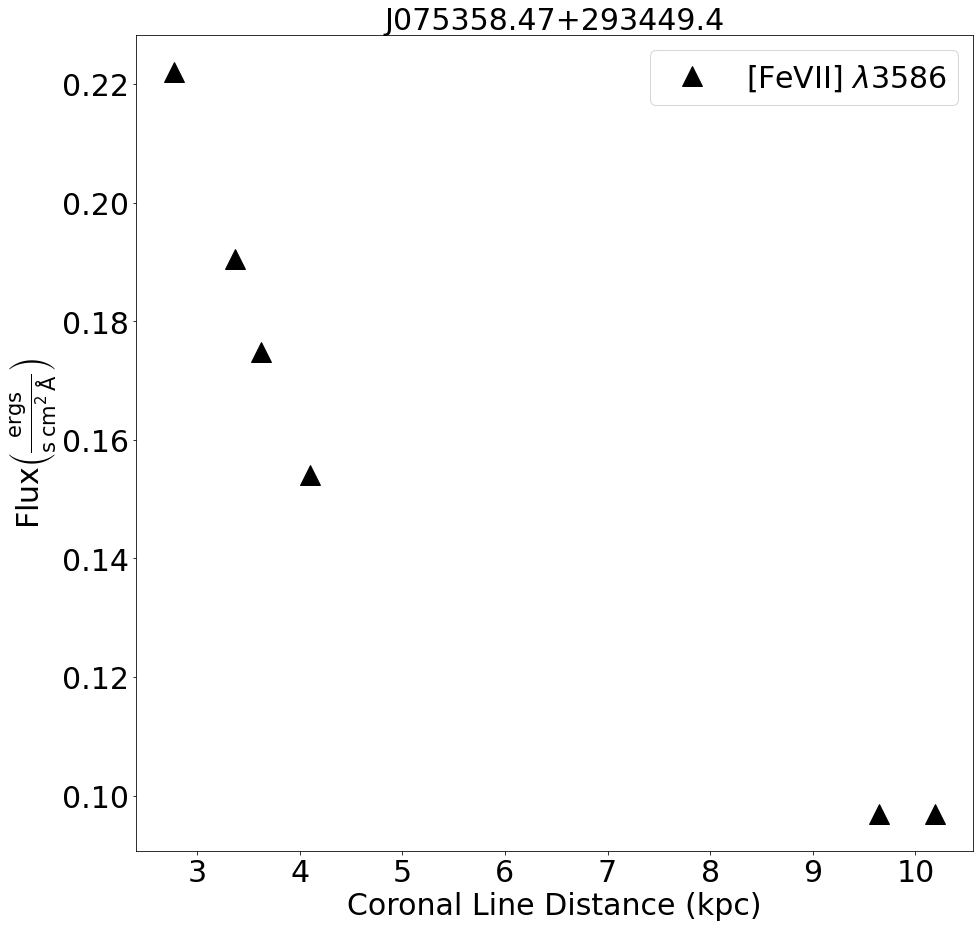

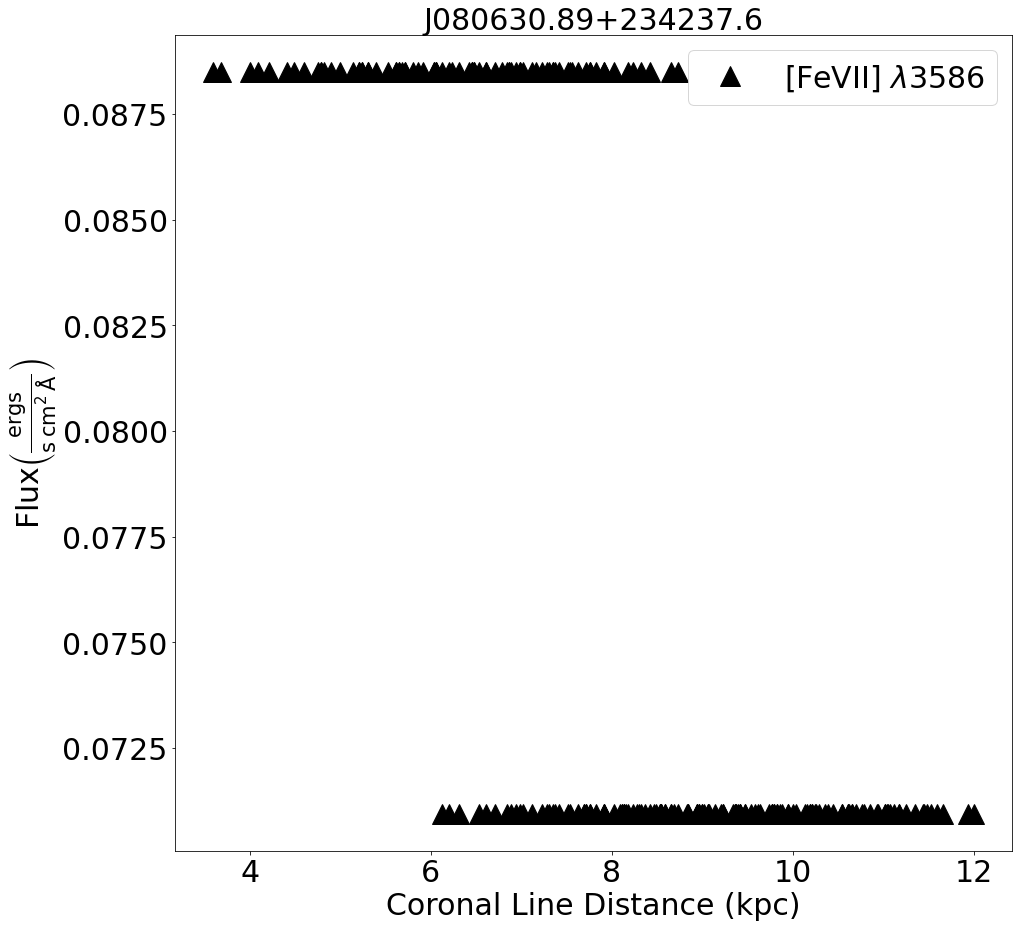

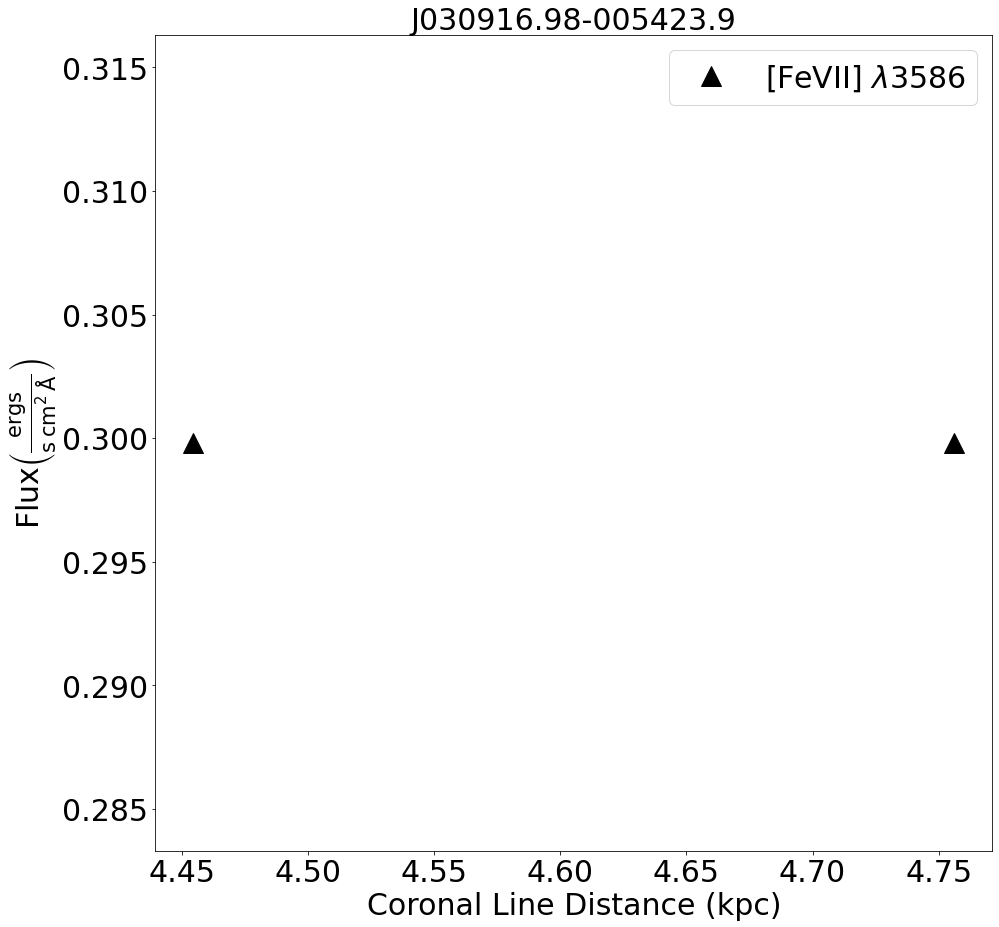

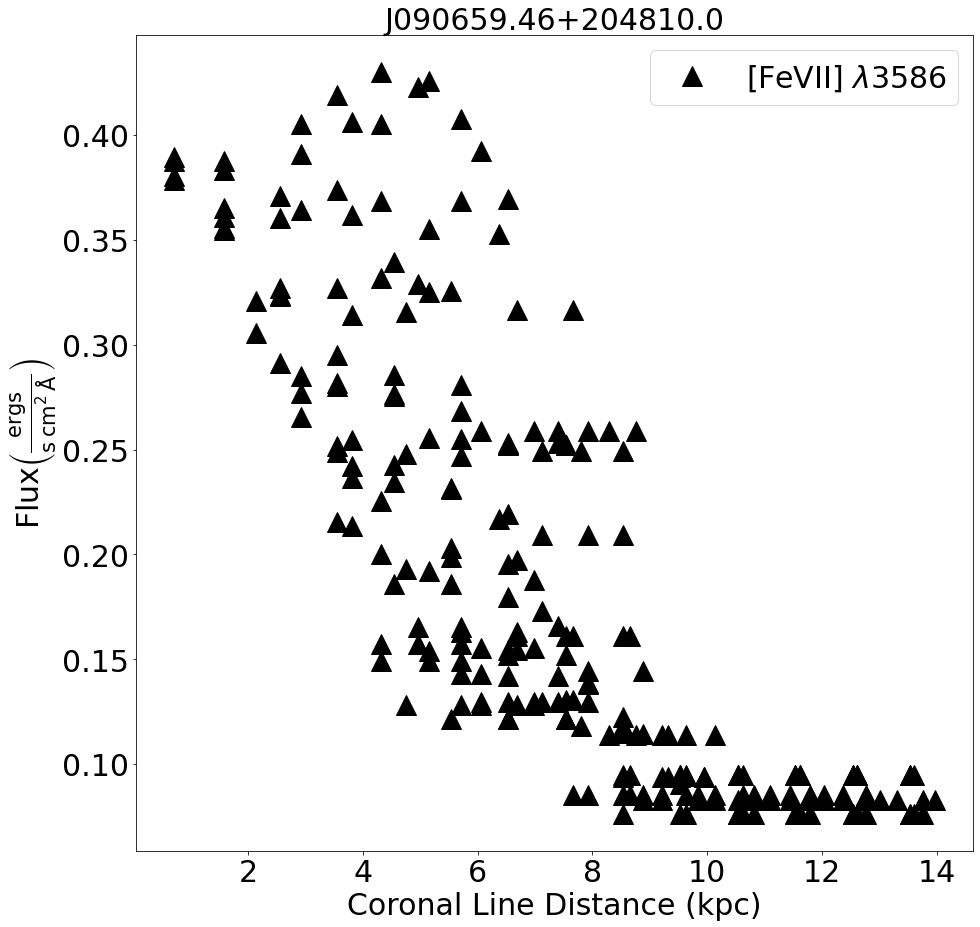

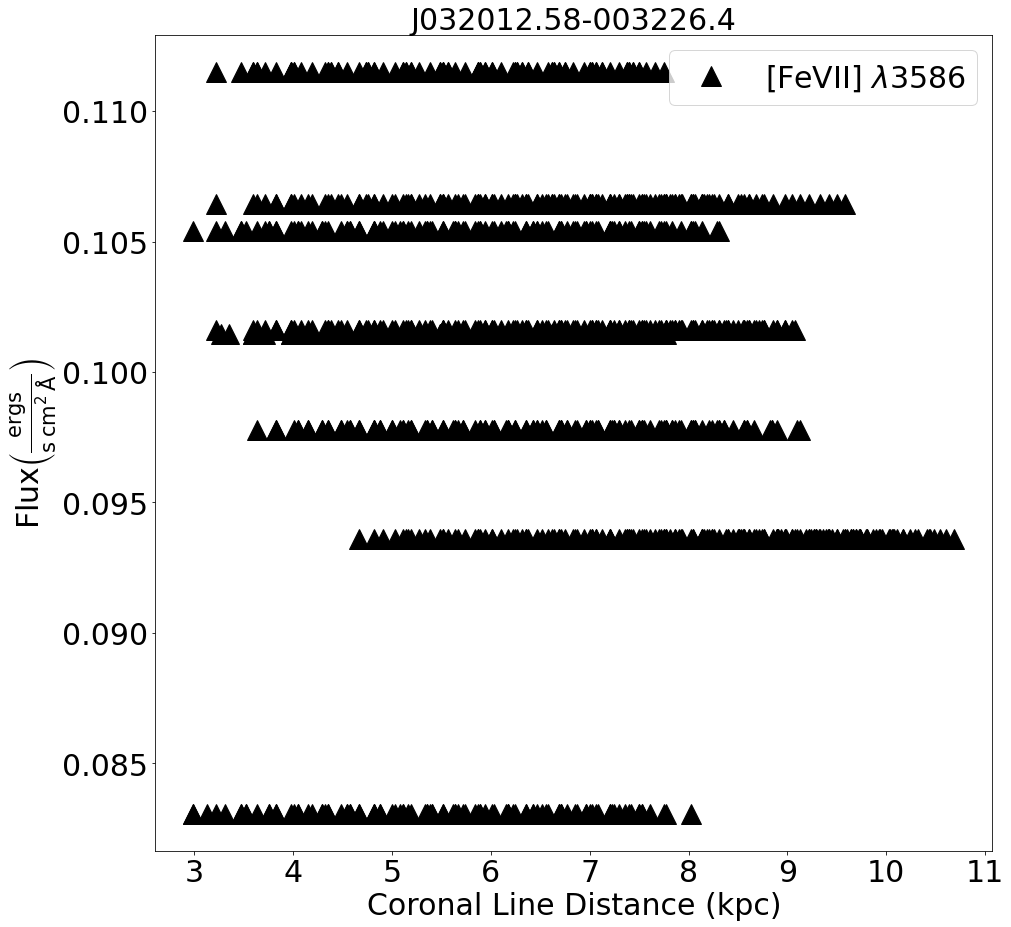

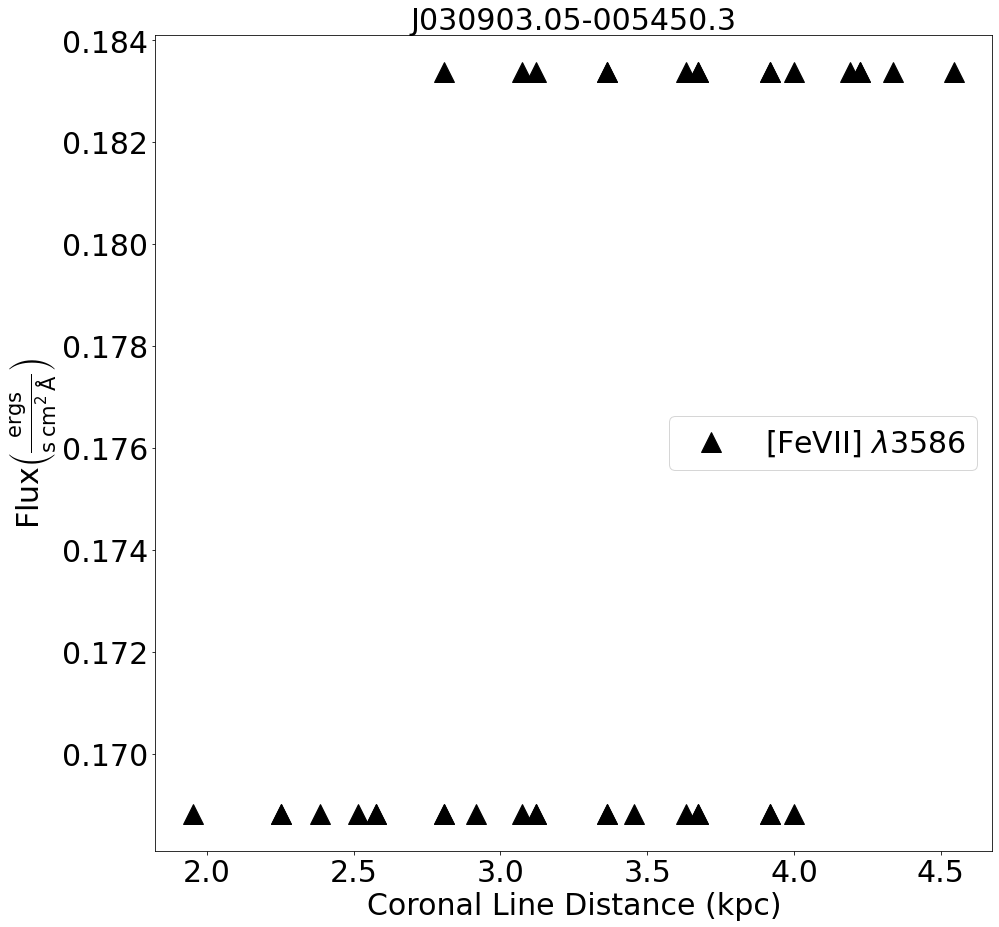

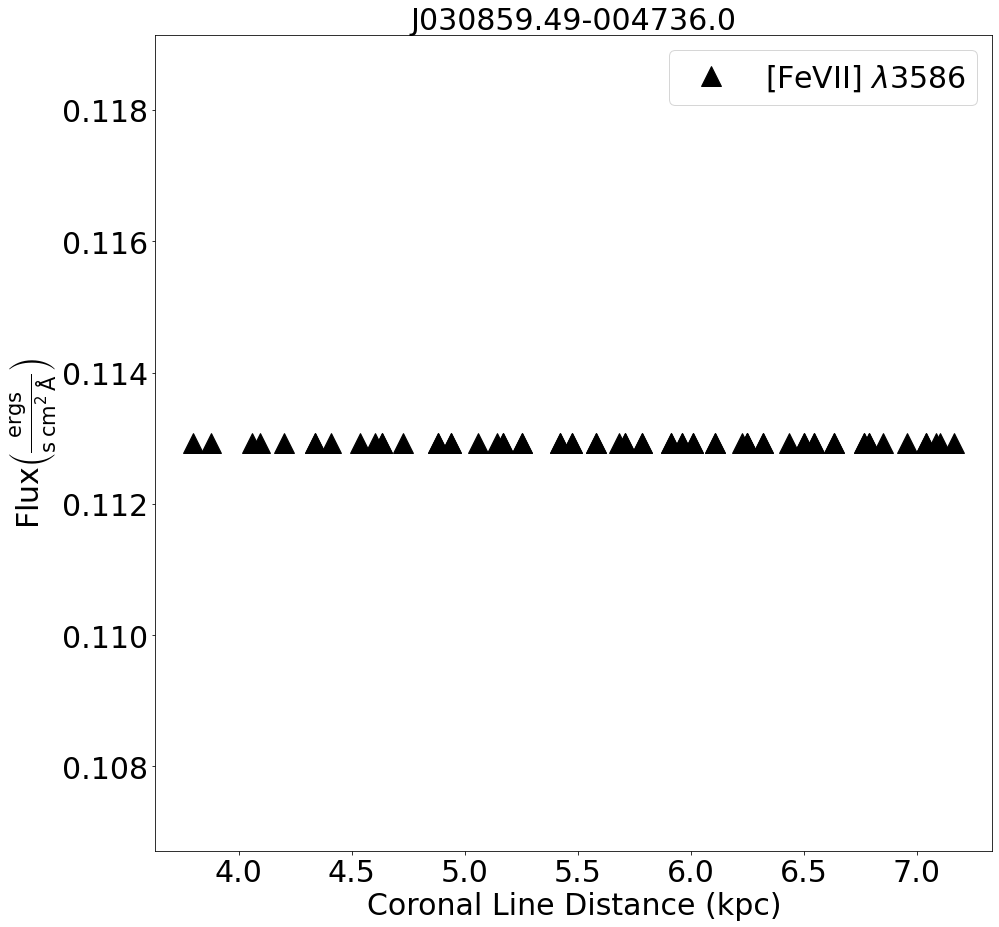

In [46]:
#Plotting the Data

def plots(emline, marker, lbl):

    data_file = ('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline + '%s'%emline + '_params.csv')
    directory = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/5_sigma/%s/'%emline)
    data = pd.read_csv(data_file)
    df = pd.DataFrame(data)
    
    for i in directory:
        if i[0] == 'J':
            iau = i
            clr = data.loc[df['IAU'] == iau]['Coronal Line Distance (kpc)']
            clf = data.loc[df['IAU'] == iau]['Coronal Line Flux (10^{-17} ergs/cm^2/A/spaxel)']  
            fwhm = data.loc[df['IAU'] == iau]['FWHM (km/s)']  
            ew = data.loc[df['IAU'] == iau]['EW (Angstrom)']  
    
            fs = 30
            plt.figure(figsize=(15,15))
            plt.title(iau, fontsize = fs)
            plt.plot(clr, clf, marker, label = lbl, markersize = 20)
            plt.ylabel ('Flux' + r'$\left(\frac{\rm{ergs}}{s \> cm^{2}\> \AA}\right)$', fontsize = fs)
            plt.xlabel('Coronal Line Distance (kpc)', fontsize = fs)
            plt.tick_params(labelsize=fs)
            plt.legend(fontsize = fs)
            #plt.savefig(emline + '_' + 'bol.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
            #plt.xscale('log')
            plt.show()
            plt.close()
    
    return; 

#plots(emline = 'NeV_3346.79A', lbl = '[NeV] $\lambda$3346.79', marker = 'b^')
#plots(emline = 'NeV_3426.85A', lbl = '[NeV] $\lambda$3426.85', marker = 'r^')
#plots(emline = 'FeVII_3586A', lbl = '[FeVII] $\lambda$3586', marker = 'k^')
# plots(emline = 'FeVII_3760A', lbl = '[FeVII] $\lambda$3760', marker = 'c^')
# plots(emline = 'FeVII_6086A', lbl = '[FeVII] $\lambda$6086', marker = 'm^')
# plots(emline = 'FeX_6374A', lbl = '[FeX] $\lambda$6374', marker = 'g^')

In [10]:
#Coronal Line Distance

m = open('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + 'clr' + ".csv","a+")
# m.write('IAU' + ',' + 'Emission Line' + ',' + 'CLR (pc)' + ',' + 'PSF (pc)' + ',' 
#         + 'Spaxel Size (pc)' + ',' + 'SFR (h-2 Msun/yr)' + ',' + 'Offset Velocity (km/s)' + ',' + 'Galaxy Type' + ',' + 
#         'Total OIII Flux (ergs/cm^2/A/spaxel)' + ',' + 'Total HAlpha Flux (ergs/cm^2/A/spaxel)' + 
#         ',' + 'Total CLR Flux (ergs/cm^2/A/spaxel)' + ',' + 'Redshift' + ',' + 'Bolometric Luminosity')
# d = open('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + 'distance_flux' + ".csv","a+")
# d.write('IAU' + ',' + 'Emission Line' + ',' + 'Distance (pc)' + ',' + 'OIII Flux (ergs/cm^2/A/spaxel)' + 
#         ',' + 'HAlpha Flux (ergs/cm^2/A/spaxel)' + ',' + 'CLR Flux (ergs/cm^2/A/spaxel)' + ',' + 'FWHM (km/s)')
survey = []
survey_1 = []
def output_file(emline, lbl):

    path = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/' %emline)
    z = 0
    for i in path:
        if path[z][0] == 'J':
#             os.makedirs('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/'%emline + '%s/'%path[z] + 'data')
#             os.makedirs('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/'%emline + '%s/'%path[z] + 'spectra')
#             path2 = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/' %emline + '%s/' %path[z])
#             for j in path2:  
#                 if j[-3:] == 'csv':
#                     shutil.move('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/'%emline + '%s/'%path[z] + '%s' %j, 
#                                 '/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/'%emline + '%s/'%path[z] + 'data/')
#                 if j[-3:] == 'png':
#                     shutil.move('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/'%emline + '%s/'%path[z] + '%s' %j, 
#                     '/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/'%emline + '%s/'%path[z] + 'spectra/')
            
            g = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/'%emline + '%s/'%path[z] + 'data/')
            ind = np.where(tbdata['nsa_iauname'] == str(path[z])) 
            plateifu1 = tbdata['plateifu'][ind][0]
            mangaid = tbdata['mangaid'][ind][0]
            redshift = tbdata['z'][ind][0]
            iau = tbdata['nsa_iauname'][ind][0] #Finding SDSS Name
            ind_2 = np.where(tbdata_1['mangaid'] == mangaid)
            ldist = tbdata_1['LDIST_NSA_Z'][ind_2][0]

#             plate = tbdata['plate'][ind][0]
#             ind_2 = np.where(emline_data['plateid'] == str(plate))
# #             test = emline_data[ind_2]
# #             print (emline_data[200000])
            
            if len(plateifu1) == 9:
                plate = plateifu1[0:4]
                ifu = plateifu1[5:9]
            if len(plateifu1) == 10 and plateifu1[0] != '1':
                plate = plateifu1[0:4]
                ifu = plateifu1[5:10]
            if len(plateifu1) == 10 and plateifu1[0] == '1':
                plate = plateifu1[0:5]
                ifu = plateifu1[6:10]
            if len(plateifu1) == 11:
                plate = plateifu1[0:5]
                ifu = plateifu1[6:11]
            hdulist = fits.open('output/fits/%s/' %emline + 'logcube/' + 'manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE-VOR10-MILESHC-MILESHC.fits')
            hdu = fits.open('output/fits/%s/' %emline + 'maps/' + 'manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits')
            flux_import = hdulist[1].data
            spaxe1,spaxel2,spaxel3 = flux_import.shape
            
            #Importing Emission Lines
            oiii_5007_import = hdu['EMLINE_GFLUX'].data[13,:,:]
            oiii_4959_import = hdu['EMLINE_GFLUX'].data[12,:,:]
            halpha_import = hdu['EMLINE_GFLUX'].data[18,:,:]
            sii_6718_import = hdu['EMLINE_GFLUX'].data[20,:,:]
            sii_6732_import = hdu['EMLINE_GFLUX'].data[21,:,:]
            oi_6365_import = hdu['EMLINE_GFLUX'].data[16,:,:]
            oi_6302_import = hdu['EMLINE_GFLUX'].data[15,:,:]



#             amp_1 = []
#             r_test = []
#             dist_1 = []
#             oiii_5007_array = []
#             oiii_4959_array = []
#             halpha_array = []
#             sii_6718_array = []
#             sii_6732_array = []
#             snr_array = []
#             temp_array = []
#             density_array = []
#             fwhm_array = []
            
#             flux_array = np.zeros((spaxel2, spaxel3))
#             vdisp_array = np.zeros((spaxel2, spaxel3))
#             voffset_array = np.zeros((spaxel2, spaxel3))
#             oiii_5007_flux_array = np.zeros((spaxel2, spaxel3))
#             oiii_4959_flux_array = np.zeros((spaxel2, spaxel3))
#             halpha_flux_array = np.zeros((spaxel2, spaxel3))
#             sii_6718_flux_array = np.zeros((spaxel2, spaxel3))
#             sii_6732_flux_array = np.zeros((spaxel2, spaxel3))
#             snr_flux_array = np.zeros((spaxel2, spaxel3))
#             temp_flux_array = np.zeros((spaxel2, spaxel3))
#             density_flux_array = np.zeros((spaxel2, spaxel3))
#             oi_6365_flux_array = np.zeros((spaxel2, spaxel3))
#             oi_6302_flux_array = np.zeros((spaxel2, spaxel3))
#             oi_diff_flux_array = np.zeros((spaxel2, spaxel3))
#             residual_flux_array = np.zeros((spaxel2, spaxel3))

#             for j in g:
#                 if j[-3:] == 'csv':
#                     x = j[0:2]
#                     y = j[2:4]
                    
#                     data_file = ('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/'%emline + '%s/'%path[z] + 'data/' 
#                                  + '%s' %x + '%s' %y + 'data.csv' )
#                     try:
#                         data = pd.read_csv(data_file, delimiter = ',')
#                     except FileNotFoundError:
#                         continue
                        
#                     oi_6365 = oi_6365_import[int(x),int(y)]
#                     oi_6302 = oi_6302_import[int(x),int(y)]
#                     if oi_6365 == 0.0:
#                         oi_diff = 0.0
#                     else:
#                         oi_diff = oi_6302/oi_6365
                    
# #                     if oi_diff > 3:
# #                         continue

# #                     if oi_diff < 3:
                        
#                     amp = data['Gaussian Amplitude (ergs/cm^2/A/spaxel)'][0]
#                     fwhm = data['FWHM'][0]
#                     fwhm_array.append(fwhm)
#                     sigma = data['Sigma (km/s)'][0]
#                     sfr = data['SFR (h-2 Msun/yr)'][0]
#                     vel_off = data['Offset Velocity (km/s)'][0] 
#                     amp_1.append(amp)

#                     oiii_5007 = oiii_5007_import[int(x),int(y)]
#                     oiii_4959 = oiii_4959_import[int(x),int(y)]
#                     halpha = halpha_import[int(x),int(y)]
#                     sii_6718 = sii_6718_import[int(x),int(y)]
#                     sii_6732 = sii_6732_import[int(x),int(y)]

#                        # print (str(plate) + '-' + str(ifu) + ' ' + str(iau) + ' ' + str(emline) + '\n' + 'Total Array Size = ' + str(spaxel2) + ' x ' + str(spaxel3) + '\n')

# #                     resid = np.abs(oi_6365 - amp)
# #                     r_test.append(resid)

#                     try:
#                         snr = (sii_6718 + sii_6732)/halpha
#                     except RuntimeWarning:
#                         snr = 0
#                     if snr < 0.4:
#                         snr = 0
#                     snr_array.append(snr)

#                     data_file_2 = ('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + 'OI_4364/' + '%s/'%path[z] + 'data/' 
#                                  + '%s' %x + '%s' %y + 'data.csv' )
#                     try:
#                         data = pd.read_csv(data_file, delimiter = ',')
#                     except FileNotFoundError:
#                         continue

#                     amp_oi = data['Gaussian Amplitude (ergs/cm^2/A/spaxel)'][0]
                    
#                     try:
#                         density = sii_6732/sii_6718
#                     except RuntimeWarning:
#                         density = 0
                        
#                     try:
#                         temp = amp_oi/(oiii_5007 + oiii_4959)
#                     except RuntimeWarning:
#                         temp = 0

# # #                    oiii_array.append(oiii)
# # #                     halpha_array.append(oiii)
# # #                     nii_array.append(nii)
# # #                     nii_1_array.append(nii_1)


#                     flux_array[int(x)][int(y)] = amp
#                     vdisp_array[int(x)][int(y)] = sigma
#                     voffset_array[int(x)][int(y)] = vel_off
#                     oiii_5007_flux_array[int(x)][int(y)] = oiii_5007
#                     halpha_flux_array[int(x)][int(y)] = halpha
#                     sii_6718_flux_array[int(x)][int(y)] = sii_6718
#                     sii_6732_flux_array[int(x)][int(y)] = sii_6732
#                     snr_flux_array[int(x)][int(y)] = snr
#                     oi_6365_flux_array[int(x)][int(y)] = oi_6365
#                     #residual_flux_array[int(x)][int(y)] = resid 
# #                     else: 
# #                         continue

#                     pn.log_.level = 2
#                     obs = pn.Observation()
#                     diags = pn.Diagnostics()
#                     diags.addDiag('[SII] 6731/6716', '[OIII] 4363/5007+')
#                     Te, Ne = diags.getCrossTemDen('[OIII] 4363/5007+', '[SII] 6731/6716', temp, density)

# #                     print ('Te = {0:5.0f} K, Ne = {1:7.1f} cm-3'.format(Te, Ne))
# #                     print (Te, Ne)
#                     temp_flux_array[int(x)][int(y)] = Te 
#                     density_flux_array[int(x)][int(y)] = Ne

#                     temp_array.append(Te)
#                     density_array.append(Ne)


# # #                     d.write('\n' + iau + ',' + emline + ',' + str(true_distance) + ',' + str(oiii) + ',' + str(halpha) + ',' + str(amp) + ',' + str(fwhm))
#                     total_cl_amp = np.sum(amp_1)
            
#                     ind_2 = np.where(tbdata_1['mangaid'] == mangaid)

#                     if len(ind_2[0]) == 3:
#                         vor_10_ind_2 = ind_2[0][1]
#                     if len(ind_2[0]) == 6:
#                         vor_10_ind_2 = ind_2[0][2]
#                     if len(ind_2[0]) == 9:
#                         vor_10_ind_2 = ind_2[0][3]  

#                     oiii_tot = tbdata_1['EMLINE_GFLUX_TOT'][vor_10_ind_2][13]
#                     halpha_tot = tbdata_1['EMLINE_GFLUX_TOT'][vor_10_ind_2][18]

#                     clr = dist_1[np.argmax(dist_1)]
#                     if clr == 0:
#                         clr = 1
#                     psf = 2.5*spaxel_size
            
# # #             shutil.rmtree('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/'%emline + '%s/'%iau + 'maps/')
 
# # #             os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.' 
# # #                       'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-8/VOR10-MILESHC-MILESHC/' + 
# # #                       str(plate)+'/'+str(ifu)+'/qa/manga-%s' %plate + '-' +
# # #                       '%s' %ifu +'-LOGCUBE-VOR10-MILESHC-MILESHC-el-fitqa-maps.png output/5_sigma/%s/' %emline + '%s/' %str(iau) + 'maps/')

            
#             m.write('\n' + str(iau) + ',' + str(emline) + ',' + str(clr) + ',' + str(psf) + ',' 
#                     + str(spaxel_size) + ',' + str(sfr) + ',' + str(vel_off) + ',' + str(gc) + ',' 
#                     + str(oiii_tot) + ',' + str(halpha_tot) + ',' + str(total_cl_amp) + ',' + str(redshift) + ',' + str(oiii_bol))
#             try:
#                 fwhm_avg = np.average(fwhm_array)
#             except RuntimeWarning:
#                 fwhm_avg = 0
#             print (fwhm_avg)
            print (str(plate) + '-' + str(ifu) + ' ' + str(iau) + ' ' + str(emline) + '\n' + 'Total Array Size = ' + str(spaxel2) + ' x ' + str(spaxel3) + '\n')
    
#             newpath_maps = r'/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/'%emline + '%s/'%iau + 'maps/'
#             if not os.path.exists(newpath_maps):
#                 os.makedirs(newpath_maps)
                
#             newpath_plots = r'/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/'%emline + '%s/'%iau + 'plots/'
#             if not os.path.exists(newpath_plots):
#                 os.makedirs(newpath_plots)
                
#             fs = 30
#             plt.figure(figsize=(15,15))
#            # plt.title('Distance vs Flux' + '\n' + '(' + path[z] + ')', fontsize = fs)
#             plt.plot(dist_1, r_test, 'g^', label = '[FeX]$\lambda$6374')
#             plt.xlabel ('Distance (pc)', fontsize = fs)
#             plt.ylabel('Flux ($10^{-17}$ $ergs$ $s^-1$ $cm^{-2}$ $\AA^{-1})$', fontsize = fs)
#             plt.tick_params(labelsize=fs)
#             plt.legend(fontsize = fs)
#             plt.xlim(0,)
#             #plt.savefig(newpath_plots + path[z] + '_' + 'dflux.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
#             plt.show()
#             plt.close()


                
# #             # Opens a image in RGB mode 
# #             try:
# #                 im = Image.open(newpath + 'manga-%s' %plate + '-' + '%s' %ifu + '-LOGCUBE-VOR10-MILESHC-MILESHC-el-fitqa-maps.png') 
# #             except FileNotFoundError:
# #                 print ('No SDSS Image')
# #                 pass
# #             width, height = im.size 

# #             # Setting the points for cropped image 
# #             left = 28
# #             top = height / 10.6
# #             right = 200
# #             bottom = 3 * height / 8.3

# #             im1 = im.crop((left, top, right, bottom)) 
# #             im2 = im1.resize((400, 400)) 

# #             # Shows the image in image viewer 
# #             im2.save(newpath +  iau + '_' + 'SDSS.png', 'PNG')
            #x, y = flux_array.shape
            #fs = 50
#             fig, (ax1) = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15,15))
#             cax1 = ax1.imshow(snr_flux_array, cmap='magma', origin = 'lower', extent = [(-x*spaxel_size)/1000, (x*spaxel_size)/1000,
#                                                                                     (-x*spaxel_size)/1000, (x*spaxel_size/1000)])
#             #ax1.set_title('[OI]$\lambda6365$ Flux Map' + '\n' + '(' + iau + ')', fontsize=fs)
#             ax1.set_xlabel('kpc', fontsize=fs)
#             ax1.set_ylabel('kpc', fontsize=fs)
#             ax1.tick_params(labelsize=fs)
#             cb = fig.colorbar(cax1, ax = ax1, fraction=0.046, pad=0.04, orientation="vertical") 
#             cb.set_label('Flux ($10^{-17}$ $ergs$ $s^{-1}$ $cm^{-2}$ $\AA^{-1})$', size=fs)
#             cb.ax.tick_params(labelsize=fs)
#             plt.show()
#             fig.savefig(newpath_maps +  iau + '_' + 'snr.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
#             plt.close()
#             temp_array_1 = []
#             for i in temp_array:
#                 if str(i) == 'nan':
#                     i = temp_array[1]
#                 temp_array_1.append(i)

#             min_0, max_0 = np.argmin(temp_array_1), np.argmax(temp_array_1)
#             min_1, max_1 = temp_array_1[min_0], temp_array_1[max_0]
#             survey.append(min_1)
#             survey_1.append(max_1)
           # kpc = np.divide(dist_1,1000)
#             t_red = np.divide(temp_array,1000)
#             plt.figure(figsize=(15,15))
#             #plt.title('Temperature (K) vs. Distance', fontsize = fs)
#             plt.scatter(kpc, t_red)
#             plt.xlabel ('Distance (kpc)', fontsize = fs)
#             plt.ylabel('Temperature (10$^{3}$ K)', fontsize = fs)
#             plt.tick_params(labelsize=fs)
#             plt.savefig(newpath_plots + iau + '_' + 'temp.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
#             plt.show()
#             plt.close()

#             plt.figure(figsize=(15,15))
#            # plt.title('Distance vs Density (cm$^{-3}$)', fontsize = fs)
#             plt.scatter(kpc, density_array)
#             plt.xlabel ('Distance (kpc)', fontsize = fs)
#             plt.ylabel('Density (cm$^{-3}$)', fontsize = fs)
#             plt.tick_params(labelsize=fs)
#          #   plt.savefig(newpath_plots + iau + '_' + 'density.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
#             plt.show()
#             plt.close()
            
#             fig, (ax1) = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15,15))
#             cax1 = ax1.imshow(temp_flux_array, cmap='magma', origin = 'lower')
#             #ax1.set_title('[OI]$\lambda6365$ Flux Map' + '\n' + '(' + iau + ')', fontsize=fs)
#             ax1.set_xlabel('Spaxels', fontsize=fs)
#             ax1.set_ylabel('Spaxels', fontsize=fs)
#             ax1.tick_params(labelsize=fs)
#             cb = fig.colorbar(cax1, ax = ax1, fraction=0.046, pad=0.04, orientation="vertical") 
#             cb.set_label('Kelvin', size=fs)
#             cb.ax.tick_params(labelsize=fs)
#             #plt.show()
#           #  fig.savefig(newpath_maps +  iau + '_' + 'temp.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
#             plt.close()
            
#             fig, (ax1) = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15,15))
#             cax1 = ax1.imshow(density_flux_array, cmap='magma', origin = 'lower')
#             #ax1.set_title('[OI]$\lambda6365$ Flux Map' + '\n' + '(' + iau + ')', fontsize=fs)
#             ax1.set_xlabel('Spaxels', fontsize=fs)
#             ax1.set_ylabel('Spaxels', fontsize=fs)
#             ax1.tick_params(labelsize=fs)
#             cb = fig.colorbar(cax1, ax = ax1, fraction=0.046, pad=0.04, orientation="vertical") 
#             cb.set_label('cm$^{-3}$', size=fs)
#             cb.ax.tick_params(labelsize=fs)
#             #plt.show()
#           #  fig.savefig(newpath_maps +  iau + '_' + 'density.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
#             plt.close()
        
#             fig, (ax1) = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15,15))
#             cax1 = ax1.imshow(oi_import, cmap='magma', origin = 'lower')
#             #ax1.set_title('[OI]$\lambda6365$ Flux Map' + '\n' + '(' + iau + ')', fontsize=fs)
#             ax1.set_xlabel('Spaxels', fontsize=fs)
#             ax1.set_ylabel('Spaxels', fontsize=fs)
#             ax1.tick_params(labelsize=fs)
#             cb = fig.colorbar(cax1, ax = ax1, fraction=0.046, pad=0.04, orientation="vertical") 
#             cb.set_label('Flux ($10^{-17}$ $ergs$ $s^-1$ $cm^{-2}$ $\AA^{-1})$', size=fs)
#             cb.ax.tick_params(labelsize=fs)
#          #   plt.show()
#             fig.savefig(newpath +  iau + '_' + 'OI_maps.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
#             plt.close()
          
            
#             fig, (ax1) = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15,15))
#             cax1 = ax1.imshow(flux_array, cmap='magma', origin = 'lower')
#             #ax1.set_title(lbl + ' Flux Map' + '\n' + '(' + iau + ')', fontsize=fs)
#             ax1.set_xlabel('Spaxels', fontsize=fs)
#             ax1.set_ylabel('Spaxels', fontsize=fs)
#             ax1.tick_params(labelsize=fs)
#             cb = fig.colorbar(cax1, ax = ax1, fraction=0.046, pad=0.04, orientation="vertical") 
#             cb.set_label('Flux ($10^{-17}$ $ergs$ $s^-1$ $cm^{-2}$ $\AA^{-1})$', size=fs)
#             cb.ax.tick_params(labelsize=fs)
#             #plt.show()
#             fig.savefig(newpath +  iau + '_' + 'maps.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
#             plt.close()
        
#             if np.sum(snr_flux_array) > 0:
#                 fig, (ax1) = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15,15))
#                 cax1 = ax1.imshow(snr_flux_array, cmap='magma', origin = 'lower')
#                # ax1.set_title(lbl + ' Shock Flux Map' + '\n' + '(' + iau + ')', fontsize=fs)
#                 ax1.set_xlabel('Spaxels', fontsize=fs)
#                 ax1.set_ylabel('Spaxels', fontsize=fs)
#                 ax1.tick_params(labelsize=fs)
#                 cb = fig.colorbar(cax1, ax = ax1, fraction=0.046, pad=0.04, orientation="vertical") 
#                 cb.set_label('Flux ($10^{-17}$ $ergs$ $s^-1$ $cm^{-2}$ $\AA^{-1})$', size=fs)
#                 cb.ax.tick_params(labelsize=fs)
#     #            plt.show()
#                 fig.savefig(newpath +  iau + '_' + 'snr.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
#                 plt.close()

            
# #           fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, sharex=True, sharey=True, figsize=(20,20))
#             cax1 = ax1.imshow(flux_array, cmap='magma', origin = 'lower')
#             ax1.set_title(iau  + ' ' + emline, fontsize=fs)
#             ax1.set_xlabel('Spaxels', fontsize=fs)
#             ax1.set_ylabel('Spaxels', fontsize=fs)
#             fig.colorbar(cax1, ax = ax1, label = 'Flux ($10^{-17} ergs$ $s^-1$ $cm^{-2}$ $A^{-1})$')
#             cax2 = ax2.imshow(oiii_flux_array, cmap='magma', origin = 'lower')
#             ax2.set_title(iau  + ' OIII', fontsize=fs)
#             ax2.set_xlabel('Spaxels', fontsize=fs)
#             ax2.set_ylabel('Spaxels', fontsize=fs)
#             fig.colorbar(cax2, ax = ax2, label = 'Flux ($10^{-17} ergs s^-1 cm^{-2} A^{-1})$')
#             cax3 = ax3.imshow(halpha_flux_array, cmap='magma', origin = 'lower')
#             ax3.set_title(iau + ' Halpha', fontsize=fs)
#             ax3.set_xlabel('Spaxels', fontsize=fs)
#             ax3.set_ylabel('Spaxels', fontsize=fs)
#             fig.colorbar(cax3, ax = ax3, label = 'Flux ($10^{-17} ergs s^-1 cm^{-2} A^{-1})$')
#             cax4 = ax4.imshow(vdisp_array, origin = 'lower')
#             ax4.set_title(iau  + ' CL Velocity Dispersion Map', fontsize=fs)
#             ax4.set_xlabel('Spaxels', fontsize=fs)
#             ax4.set_ylabel('Spaxels', fontsize=fs)
#             fig.colorbar(cax4, ax = ax4, label = 'Sigma (km $s^-1)$')
#             cax5 = ax5.imshow(voffset_array, origin = 'lower')
#             ax5.set_title(iau  + ' CL Velocity Offset Map', fontsize=fs)
#             ax5.set_xlabel('Spaxels', fontsize=fs)
#             ax5.set_ylabel('Spaxels', fontsize=fs)
#             fig.colorbar(cax5, ax = ax5, label = 'V_Off (km $s^-1)$')

#             fig.savefig(newpath +  iau + '_' + 'maps.png', dpi=600, format='png', bbox_inches='tight', pad_inches = 0)
#             #plt.show() 
#             plt.close()
            
            

        z += 1
    
    return;
# output_file(emline = 'NeV_3346.79A', lbl = '[NeV]$\lambda$3346.79')
# output_file(emline = 'NeV_3426.85A', lbl = '[NeV]$\lambda$3426.85')
# output_file(emline = 'FeVII_3586A', lbl = '[FeVII]$\lambda$3586')
# output_file(emline = 'FeVII_3760A', lbl = '[FeVII]$\lambda$3760')
# output_file(emline = 'FeVII_6086A', lbl = '[FeVII]$\lambda$6086')
# output_file(emline = 'FeX_6374A', lbl = '[FeX]$\lambda$6374')
m.close()
#d.close()

In [13]:
#SFR Parameters

# gz2 = fits.open('MaNGA_gz-v1_0_1.fits')
# gz2_data = gz2[1].data


# data_file = ('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + 'clr.csv' )
# data = pd.read_csv(data_file, delimiter = ',')
# iau_cl = data['IAU']
# clr_dist = data['CLR (pc)']
# cl_flux_tot = data['Total CLR Flux (ergs/cm^2/A/spaxel)']
# manga_mass = tbdata['nsa_sersic_mass']
# manga_sfr_1 = tbdata_1['SFR_1RE']
# manga_sfr_tot = tbdata_1['SFR_TOT']


# for i in range (len(iau_cl) - 1):
#     ind_cl = np.where(tbdata['nsa_iauname'] == iau_cl[i]) #retrieving iau indice in tbdata
#     mangaid_cl = tbdata['mangaid'][ind_cl][0] #getting manga-id from tbdata
#     plateifu_cl = tbdata['plateifu'][ind_cl][0] #getting plateifu from tbdata
#     ind_1 = np.where(tbdata_1['mangaid'] == mangaid_cl)
#     ind_3dcl = np.where(pipe3d_data['mangaid'] == 'manga-' + str(plateifu_cl)) #matching plate-ifu of CLs with Pipe3D
#     pipecl = pipe3d_data['log_SFR_Ha'][ind_3dcl]



# kpc =  clr_dist/1000 

# def best_fit_slope_and_intercept(kpc,cl_sfr_tot):
#     m = (((mean(kpc)*mean(cl_sfr_tot)) - mean(kpc*cl_sfr_tot)) /
#          ((mean(kpc)*mean(kpc)) - mean(np.square(kpc))))
#     b = mean(cl_flux_tot) - m*mean(kpc)
#     return m,b

# m,b = best_fit_slope_and_intercept(kpc,cl_sfr_tot)

# regression_line = []
# for x in kpc:
#     regression_line.append((m*x)+b)
    

# print (linregress(kpc, cl_sfr_tot))
# fs = 30
# plt.figure(figsize=(15,15))
# #plt.title('CLR Distance vs SFR', fontsize = fs)
# plt.scatter(kpc, cl_sfr_tot)
# plt.plot(cl_sfr_tot, regression_line, 'k')
# plt.yscale('log')

# plt.ylabel ('Flux ($10^{-17}$ $ergs$ $s^{-1}$ $cm^{-2}$ $\AA^{-1})$', fontsize = fs)
# plt.xlabel('SFR ($M_{\odot}$ yr$^{-1}$ )', fontsize = fs)
# plt.tick_params(labelsize=fs)
# plt.savefig(newpath + 'sfr(1re).png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
# plt.show()
# plt.close()
# cl_flux_tot = cl_flux_tot[:-1]
# def best_fit_slope_and_intercept(cl_flux_tot, cl_sfr_tot):
#     m = (((mean(cl_flux_tot)*mean(cl_sfr_tot)) - mean(cl_flux_tot*cl_sfr_tot)) /
#          ((mean(cl_flux_tot)*mean(cl_flux_tot)) - mean(np.square(cl_flux_tot))))
#     b = mean(cl_sfr_tot) - m*mean(cl_flux_tot)
#     return m,b

# m,b = best_fit_slope_and_intercept(cl_flux_tot, cl_sfr_tot)

# regression_line = []
# for x in cl_flux_tot:
#     regression_line.append((m*x)+b)
    
# fs = 30
# plt.figure(figsize=(15,15))
# plt.title('Total CL Flux vs SFR', fontsize = fs)
# plt.scatter(cl_flux_tot, cl_sfr_tot)
# plt.plot(cl_flux_tot, regression_line, 'k')
# plt.xscale('log')

# plt.xlabel ('Flux ($10^{-17}$ $ergs$ $s^{-1}$ $cm^{-2}$ $\AA^{-1})$', fontsize = fs)
# plt.ylabel('SFR ($M_{\odot}$ yr$^{-1}$ )', fontsize = fs)
# plt.tick_params(labelsize=fs)
# plt.savefig(newpath + 'sfr(1re).png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
# plt.show()
# plt.close()


# corr, _ = pearsonr(kpc, cl_sfr_tot)
# print('Pearsons correlation: %.3f' % corr)
#corr, _ = spearmanr(kpc, cl_sfr_tot)
#print('Spearmans correlation: %.3f' % corr)

# def best_fit_slope_and_intercept(cl_sfr_tot,cl_flux_tot):
#     m = (((mean(cl_sfr_tot)*mean(cl_flux_tot)) - mean(cl_sfr_tot*cl_flux_tot)) /
#          ((mean(cl_sfr_tot)**2) - mean(cl_sfr_tot**2)))
#     b = mean(cl_flux_tot) - m*mean(cl_sfr_tot)
#     return m,b

# m,b = best_fit_slope_and_intercept(cl_sfr_tot,cl_flux_tot)

# regression_line = []
# for x in kpc:
#     regression_line.append((m*x)+b)
# plt.figure(figsize=(15,15))
# plt.title('CL Flux vs SFR (1RE)', fontsize = fs)
# plt.scatter(cl_sfr_tot, cl_flux_tot)
# #plt.plot(cl_sfr_1, regression_line, ':')
# plt.ylabel ('Flux', fontsize = fs)
# plt.xlabel('SFR ($M_{\odot}$ yr$^{-1}$ )', fontsize = fs)
# plt.tick_params(labelsize=fs)
# plt.savefig(newpath + 'sfr_cl.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
# plt.show()
# plt.close()

# plt.figure(figsize=(15,15))
# plt.title('Distance vs SFR', fontsize = fs)
# plt.scatter(clr_dist, cl_sfr_1)
# plt.plot(clr_dist, regression_line, ':')
# plt.xlabel ('Distance (pc)', fontsize = fs)
# plt.ylabel('SFR ($M_{\odot}$ yr$^{-1}$ )', fontsize = fs)
# plt.tick_params(labelsize=fs)
# plt.savefig(newpath + 'sfr.png', dpi=300, format='png', bbox_inches='tight', pad_inches = 0.25)
# plt.show()
# plt.close()

#plt.scatter(clr_dist,cl_sfr_1)

#plt.show()

# def best_fit_slope(clr_dist,cl_sfr_tot):
#     slope = (((mean(clr_dist)*mean(cl_sfr_tot)) - mean(clr_dist*cl_sfr_tot)) /
#          ((mean(clr_dist)**2) - mean(clr_dist**2)))
#     return slope

# slope = best_fit_slope(clr_dist,cl_sfr_tot)
# print(slope)

# zeros  = np.where(cl_sfr_1 < 0)
# cl_sfr_1[zeros] = 0

#Determining Morphology for MaNGA Galaxies

# tbdata_len = tbdata.shape[0]
# counter = 0
# manga_ell_counter = 0
# manga_spi_counter = 0
# manga_stellar_mass = []
# pipe_sfr_arr = []
# manga_iau = []
# oiii_2_arr = []

# for i in range (tbdata_len):
#     iau = tbdata[i]['nsa_iauname']
#     if iau not in manga_iau:
#         ind = np.where(tbdata['nsa_iauname'] == iau)
        
#         plateifu = tbdata['plateifu'][ind][0]
#         mangaid = tbdata['mangaid'][ind]
#         ind_2 = np.where(tbdata_1['mangaid'] == mangaid[0])
#         if len(iau) == 19:

#             if iau not in np.array(iau_cl):
#                 counter += 1
#                 try:
#                     gz_ind = np.where(gz2_data['IAUNAME'] == iau)
#                     ell = gz2_data['t01_smooth_or_features_a01_smooth_weight_fraction'][gz_ind][0]
#                     spr = gz2_data['t01_smooth_or_features_a02_features_or_disk_weight_fraction'][gz_ind][0]
#                     if spr > ell:
#                         gc = 'Spiral'
#                         manga_spi_counter += 1
#                     else:
#                         gc = 'Elliptical'
#                         manga_ell_counter += 1
#                 except IndexError:
#                     gc = ''

#                 ind_3d = np.where(pipe3d_data['mangaid'] == 'manga-' + str(plateifu))
#                 mass = pipe3d_data['log_Mass'][ind_3d]
#                 pipe_sfr = pipe3d_data['log_SFR_Ha'][ind_3d]
#                 if mass.shape[0] == 0:
#                     mass = 0
#                 else:
#                     mass = mass[0]
#                 manga_stellar_mass.append(mass)

#                 if pipe_sfr.shape[0] == 0:
#                     pipe_sfr = 0
#                 else:
#                     pipe_sfr = pipe_sfr[0]

#                 pipe_sfr_arr.append(pipe_sfr)
                
                
#                 ind_3dcl = np.where(pipe3d_data['mangaid'] == 'manga-' + str(plateifu_cl))

#             manga_iau.append(iau)

        
# ma.masked_where(pipe_sfr_arr == 0, pipe_sfr_arr)
# ma.masked_where(pipe_sfr_arr == 0, pipe_sfr_arr)
#print (manga_iau)

# plt.figure(figsize=(20,10))
# plt.plot(manga_stellar_mass, pipe_sfr_arr, 'go', label = 'MaNGA Catalog')
# plt.plot(cl_stellar_mass, pipecl_ar, 'ro', label = "CL Catalog")
# plt.xlabel('log(Msun)')
# plt.ylabel('log_SFR_Ha')
# plt.title('Stellar Mass vs. SFR (Halpha)')
# plt.xlim(4, 12)
# plt.ylim(-6,4)
# plt.legend()
# plt.show()
        
# print ('Average Coronal Line Distance = ' + str(np.average(clr)) + ' pc')

# I = np.sum(gaus(wavelength_bounds, *popt))
# x_bar = (1/I)*np.sum(wavelength_bounds*gaus(wavelength_bounds, *popt))
# std_1 = np.sqrt((1/I)*np.sum((wavelength_bounds - x_bar)**2*gaus(wavelength_bounds, *popt)))
# skew_lit = (1/(I*std_1**3))*np.sum((wavelength_bounds - x_bar)**3*gaus(wavelength_bounds, *popt))
# skew_scipy = skew(gaus(wavelength_bounds, *popt))

    #                     fs = 20
    #                     fs_1 = 13
    #                     fig = plt.figure(figsize=(10,10))
    #                     ax1 = plt.axes()  
    #                     #ax2 = plt.axes([0.25, 0.7, 0.15, 0.15])
    #                     ax1.plot(wavelength_bounds_total, flux_correction_total, 'b', label = 'Data')
    #                     #ax2.plot(wavelength_bounds, residuals, 'k')
    #                     #ax2.set_title('Residuals', fontsize = fs_1)
    #                     #ax2.set_ylabel('Flux', fontsize = fs_1)
    #                     #ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize = fs_1)
    #                     #ax2.tick_params(labelsize=fs_1)
    #                     ax1.set_ylabel('Flux ($10^{-17}$ $ergs$ $s^{-1}$ $cm^{-2}$ $A^{-1})$', fontsize =fs)
    #                     ax1.set_xlabel(r'Wavelength ($\AA$)', fontsize = fs)
    #                     #ax1.set_title(str(iau) + ' (' + str(plate) + '-' + str(ifu) + ')' )
    #                     ax1.set_xlim(wavelength_bounds_total[1],wavelength_bounds_total[r[0] - 1])
    #                     ax1.plot(wavelength[wavelength_min],flux_correction_total[marker], marker='|', color = 'black', linestyle='None')
    #                     ax1.text(wavelength[wavelength_min-k0], marker_threshold, em_short, fontsize=fs)
    #                     ax1.plot(wavelength[wavemin_1],flux_correction_total[marker], marker='|', color = 'purple', linestyle='None')
    #                     ax1.text(wavelength[wavemin_1-k1], marker_threshold, n1, fontsize=fs)
    #                     ax1.plot(wavelength[wavemin_2],flux_correction_total[marker], marker='|', color = 'orange', linestyle='None')
    #                     ax1.text(wavelength[wavemin_2-k2], marker_threshold, n2, fontsize=fs)
    #                     ax1.plot(wavelength[wavemin_3],flux_correction_total[marker], marker='|', color = 'green', linestyle='None')
    #                     ax1.text(wavelength[wavemin_3-k3], marker_threshold, n3, fontsize=fs)
    #                     ax1.plot(wavelength[wavemin_4],flux_correction_total[marker], marker='|', color = 'magenta', linestyle='None')
    #                     ax1.text(wavelength[wavemin_4-k4], marker_threshold, n4, fontsize=fs)
    #                     ax1.plot(wavelength[wavemin_5],flux_correction_total[marker], marker='|', color = 'cyan', linestyle='None')
    #                     ax1.text(wavelength[wavemin_5-k5], marker_threshold, n5, fontsize=fs)
    #                     ax1.plot(wavelength[wavemin_6],flux_correction_total[marker], marker='|', color = 'pink', linestyle='None')
    #                     ax1.text(wavelength[wavemin_6-k6], marker_threshold, n6, fontsize=fs)
    #                     ax1.axvline(x = wavelength[x_0], linestyle = '--', color = 'r')
    #                     ax1.axvline(x = wavelength[x_1], linestyle = '--', color = 'r')
    #                     ax1.axvline(x = wavelength[ncl_1], linestyle = '-', color = 'k')
    #                     ax1.axvline(x = wavelength[ncl_2], linestyle = '-', color = 'k')
    #                     ax1.tick_params(labelsize=fs)

    #                     if ncl_1 == 5:
    #                         print ('test')
    #                         #ax1.text(wavelength[ncl_1 + 5], marker_threshold, 'NC', fontsize=fs)
    #                     elif emline == NeV_3346 and (ncl_bounds[0] == ncr_bounds[0]):
    #                         print ('Same Bounds')
    #                     else:
    #                         print ('test')
    #                         #ax1.text(wavelength[ncl_1 + 10], marker_threshold, 'Neighboring Continuum', fontsize=fs_1)
    #                     if emline == NeV_3426 and iau != 'J073623.13+392617.7':
    #                         ax1.axvline(x = wavelength[ncr + 5], linestyle = '-', color = 'k')
    #                         ax1.axvline(x = wavelength[x_1 + 8*bounds + 10], linestyle = '-', color = 'k')
    #                         #ax1.text(wavelength[ncr + 15], marker_threshold, 'Neighboring Continuum', fontsize=fs_1)
    #                     elif emline == NeV_3426 and iau == 'J073623.13+392617.7':
    #                         print ('J073623.13+392617.7')
    #                     else:
    #                         ax1.axvline(x = wavelength[x_1 + 5], linestyle = '-', color = 'k')
    #                         ax1.axvline(x = wavelength[ncr], linestyle = '-', color = 'k')
    #                         #ax1.text(wavelength[x_1 + 15], marker_threshold, 'Neighboring Continuum', fontsize=fs_1)
    #                     ax1.plot(wavelength_range,gaus(wavelength_range, *popt), 'r-', label = 'Best Fit')
    #                     ax1.legend(loc = 0, fontsize =fs)
    #                     try:
    #                         fig.savefig(newpath_spectra + iau + '_' + emline_name + '_%s' %l + '%s' %m + '.png', format='png', bbox_inches='tight', dpi=400, pad_inches = 0.1)
    #                     except ValueError:
    #                         fig.savefig(newpath_spectra + iau + '_' + emline_name + '_%s' %l + '%s' %m + '.png', format='png', dpi=400, pad_inches = 0.1)
    #                     plt.show()
    #                     plt.close()


In [26]:
#Julie's Catalog

drpall = fits.open('drpall-v2_5_3.fits') #Opening drpall file
tbdata = drpall[1].data #Accessing drpall data

directory = '5_sigma'

data_file_1 = ('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + 'clr.csv' )
data_1 = pd.read_csv(data_file_1, delimiter = ',')
iau_name = data_1['IAU']

julie = fits.open('MaNGA_MPL8.fits')
julie_data = julie[1].data

x = julie_data.shape
counter = 0
iau_list = []
#iau_list.append('SDSS Name')
for i in range (x[0]):
    ind = np.where(tbdata['plateifu'] == str(julie_data[i][1]))
    iau = tbdata['nsa_iauname'][ind][0] #Finding SDSS Name
    if julie_data[i][19] == 1:
        iau_list.append(str(iau) + ',' + 'Wise')
    if julie_data[i][22] == 1:
        iau_list.append(str(iau) + ',' + 'BAT')
    if julie_data[i][25] == 1:
        iau_list.append(str(iau) + ',' + 'Radio')
    if julie_data[i][29] == 1:
        iau_list.append(str(iau) + ',' + 'Broad')
    else: 
        continue

# final = []
# final.append('SDSS Name' + ',' + 'Detection Method')
# for i in range (len(iau_list)):
#     if str(iau_list[i][0:19]) in str(iau_name):
#         final.append(iau_list[i])
# #         counter += 1
# #         print (counter)
#         print (iau_list[i][0:19] + ' & ' + iau_list[i][20:] +  r'\\')

#print (final)

#np.savetxt("julie_catalog.csv", final, fmt='%s')

In [5]:
#Creating Results File

directory = '5_sigma'

f= open('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + 'results' + ".csv","a+")

    
f.write('FeVII_3586' + ',' + 'FeVII_3760' + ',' +'FeVII_6086' + ',' +'FeX_6374' + ',' +'NeV_3346.79' + ',' +'NeV_3426.85' + ',' + 'Spaxel Array'
                                + ',' + 'SDSS Name' + ',' + 'Redshift' + ',' + 'Distance (Mpc)' + ',' + '5 Sigma Threshold (ergs/cm^2/A/spaxel)'
                                 + ',' + 'Gaussian Amplitude (ergs/cm^2/A/spaxel)' + ',' 
                                + 'Gaussian Amplitude Error (ergs/cm^2/A/spaxel)'+ ',' 
                                + 'Gaussian Centroid (A)' + ',' + 'Gaussian Centroid Error (A)' + ',' 
                                + 'Gaussian Sigma (A)' + ',' 
                                + 'Gaussian Sigma Error (A)'+ ','+ 'Sigma (km/s)' + ',' + 'FWHM (km/s)' + ',' + 'Measured Velocity (km/s)' 
                                + ',' + 'SMBH Mass(Solar Masses)' + ',' + 'Sersic Mass (Solar Masses)'+  ',' + 'Velocity Dispersion (km/s)' + ','
                                 + 'SFR (h-2 Msun/yr)' + ',' + 'Chi Squared' + ',' + 'Reduced Chi Squared' +  ',' + 'Ionization Energy (eV)' +  ','
                                + 'Skewness' + ',' + 'Spaxel Size (pc)' + ',' + 'Galaxy Type')
f.close()

In [128]:
#importing data into 'results' file.  

directory = '5_sigma'

def output_file(emline):
    path = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/' %emline)
    z = 0
    for i in path:
        for j in range (2, 75):
            if path[z][0] == 'J':
                g = ('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/'%emline + '%s/'%path[z] 
                     + '%i' %j + '%i' %j + 'data.csv' )
                try:
                    data = pd.read_csv(g, delimiter = ',')
                except FileNotFoundError:
                    continue
                sdss = data['SDSS Name']
                redshift = data['Redshift']
                d = data['Distance (Mpc)']
                flux_threshold = data['5 Sigma Threshold (ergs/cm^2/A/spaxel)']
                amp = data['Gaussian Amplitude (ergs/cm^2/A/spaxel)']
                amp_err = data['Gaussian Amplitude Error (ergs/cm^2/A/spaxel)']
                cen = data['Gaussian Centroid (A)']
                cen_err = data['Gaussian Centroid Error (A)']
                gau_sig = data['Gaussian Sigma (A)']
                gau_sig_err = data['Gaussian Sigma Error (A)']
                sig = data['Sigma (km/s)']
                fwhm = data['FWHM']
                v = data['Measured Velocity (km/s)'] 
                smbh_mass = data['SMBH Mass(Solar Masses)']
                sersic_mass = data['Sersic Mass (Solar Masses)']
                v_disp = data['Velocity Dispersion (km/s)']
                sfr = data['SFR (h-2 Msun/yr)']
                chi = data['Chi Squared']
                r_chi = data['Reduced Chi Squared']
                ip = data['Ionization Energy (eV)'] 
                skew = data['Skewness']
                spaxel_size = data['Spaxel Size (pc)']
                galaxy_type = data['Galaxy Type'] 

                f= open('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + 'results' + ".csv","a+")

                if emline == 'FeVII_3586A':
                    f.write('\n' + '1' + ',' + '' + ',' + '' + ',' + '' + ',' + '' + ',' + '' + ','  + str(j) + str (j) + ',' + str(sdss[0]) +  ',' + str(redshift[0]) + ','+ str(d[0]) +  ',' 
                            + str(flux_threshold[0]) + ',' + str(amp[0]) + ','+ str(amp_err[0]) + ',' + str(cen[0])+ ',' 
                            + str(cen_err[0])+ ',' + str(gau_sig[0])+ ',' + str(gau_sig_err[0])+ ',' + str(sig[0]) + ',' + str(fwhm[0])
                            + ',' + str(v[0])+ ',' + str(smbh_mass[0])+ ',' + str(sersic_mass[0])+ ',' + str(v_disp[0])+ ',' + str(sfr[0]) + ',' + str(chi[0]) + ',' + str(r_chi[0])
                            + ',' + str(ip[0]) + ',' + str(skew[0]) + ',' + str(spaxel_size[0]) + ',' + str(galaxy_type[0]))
                if emline == 'FeVII_3760A':
                    f.write('\n' + '' + ',' + '1' + ',' + '' + ',' + '' + ',' + '' + ',' + '' + ',' + str(j) + str (j) + ',' + str(sdss[0]) +  ',' + str(redshift[0]) + ','+ str(d[0]) +  ',' 
                            + str(flux_threshold[0]) + ',' + str(amp[0]) + ','+ str(amp_err[0]) + ',' + str(cen[0])+ ',' 
                            + str(cen_err[0])+ ',' + str(gau_sig[0])+ ',' + str(gau_sig_err[0])+ ',' + str(sig[0]) + ',' + str(fwhm[0])
                            + ',' + str(v[0])+ ',' + str(smbh_mass[0])+ ',' + str(sersic_mass[0])+ ',' + str(v_disp[0])+ ',' + str(sfr[0]) + ',' + str(chi[0]) + ',' + str(r_chi[0])
                            + ',' + str(ip[0]) + ',' + str(skew[0]) + ',' + str(spaxel_size[0]) + ',' + str(galaxy_type[0]))
                if emline == 'FeVII_6086A':
                    f.write('\n' + '' + ',' + '' + ',' + '1' + ',' + '' + ',' + '' + ',' + '' + ',' + str(j) + str (j) + ',' + str(sdss[0]) +  ',' + str(redshift[0]) + ','+ str(d[0]) +  ',' 
                            + str(flux_threshold[0]) + ',' + str(amp[0]) + ','+ str(amp_err[0]) + ',' + str(cen[0])+ ',' 
                            + str(cen_err[0])+ ',' + str(gau_sig[0])+ ',' + str(gau_sig_err[0])+ ',' + str(sig[0]) + ',' + str(fwhm[0])
                            + ',' + str(v[0])+ ',' + str(smbh_mass[0])+ ',' + str(sersic_mass[0])+ ',' + str(v_disp[0])+ ',' + str(sfr[0]) + ',' + str(chi[0]) + ',' + str(r_chi[0])
                            + ',' + str(ip[0]) + ',' + str(skew[0]) + ',' + str(spaxel_size[0]) + ',' + str(galaxy_type[0]))
                if emline == 'FeX_6374A':
                    f.write('\n' + '' + ',' + '' + ',' + '' + ',' + '1' + ',' + '' + ',' + '' + ',' + str(j) + str (j) + ',' + str(sdss[0]) +  ',' + str(redshift[0]) + ','+ str(d[0]) +  ',' 
                            + str(flux_threshold[0]) + ',' + str(amp[0]) + ','+ str(amp_err[0]) + ',' + str(cen[0])+ ',' 
                            + str(cen_err[0])+ ',' + str(gau_sig[0])+ ',' + str(gau_sig_err[0])+ ',' + str(sig[0]) + ',' + str(fwhm[0])
                            + ',' + str(v[0])+ ',' + str(smbh_mass[0])+ ',' + str(sersic_mass[0])+ ',' + str(v_disp[0])+ ',' + str(sfr[0]) + ',' + str(chi[0]) + ',' + str(r_chi[0])
                            + ',' + str(ip[0]) + ',' + str(skew[0]) + ',' + str(spaxel_size[0]) + ',' + str(galaxy_type[0]))
                if emline == 'NeV_3346.79A':
                    f.write('\n' + '' + ',' + '' + ',' + '' + ',' + '' + ',' + '1' + ',' + '' + ',' + str(j) + str (j) + ',' + str(sdss[0]) +  ',' + str(redshift[0]) + ','+ str(d[0]) +  ',' 
                            + str(flux_threshold[0]) + ',' + str(amp[0]) + ','+ str(amp_err[0]) + ',' + str(cen[0])+ ',' 
                            + str(cen_err[0])+ ',' + str(gau_sig[0])+ ',' + str(gau_sig_err[0])+ ',' + str(sig[0]) + ',' + str(fwhm[0])
                            + ',' + str(v[0])+ ',' + str(smbh_mass[0])+ ',' + str(sersic_mass[0])+ ',' + str(v_disp[0])+ ',' + str(sfr[0]) + ',' + str(chi[0]) + ',' + str(r_chi[0])
                            + ',' + str(ip[0]) + ',' + str(skew[0]) + ',' + str(spaxel_size[0]) + ',' + str(galaxy_type[0]))
                if emline == 'NeV_3426.85A':
                    f.write('\n' + '' + ',' + '' + ',' + '' + ',' + '' + ',' + '' + ',' + '1' + ',' + str(j) + str (j) + ',' + str(sdss[0]) +  ',' + str(redshift[0]) + ','+ str(d[0]) +  ',' 
                            + str(flux_threshold[0]) + ',' + str(amp[0]) + ','+ str(amp_err[0]) + ',' + str(cen[0])+ ',' 
                            + str(cen_err[0])+ ',' + str(gau_sig[0])+ ',' + str(gau_sig_err[0])+ ',' + str(sig[0]) + ',' + str(fwhm[0])
                            + ',' + str(v[0])+ ',' + str(smbh_mass[0])+ ',' + str(sersic_mass[0])+ ',' + str(v_disp[0])+ ',' + str(sfr[0]) + ',' + str(chi[0]) + ',' + str(r_chi[0])
                            + ',' + str(ip[0]) + ',' + str(skew[0]) + ',' + str(spaxel_size[0]) + ',' + str(galaxy_type[0]))
                f.close()
        z += 1
    
    return;
output_file(emline = 'FeVII_3586A')
output_file(emline = 'FeVII_3760A')
output_file(emline = 'FeVII_6086A')
output_file(emline = 'FeX_6374A')
output_file(emline = 'NeV_3346.79A')
output_file(emline = 'NeV_3426.85A')

#sorting data by SDSS name

df = pd.read_csv('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + 'results.csv')
sorted_data = df.sort_values("SDSS Name")
sorted_data.to_csv('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + 'results.csv', index=False)

In [39]:
#creating LaTeX table 

data_path = ('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + 'clr.csv' )
data = pd.read_csv(data_path, delimiter = ',')
# fevii_3586 = data['FeVII_3586']
# fevii_3760 = data['FeVII_3760']
# fevii_6086 = data['FeVII_60 86']
# fex = data['FeX_6374']
# nev = data['NeV_3346.79']
# nev_1 = data['NeV_3346.79']
sdss = data['IAU']
redshift = data['Redshift']
clr = data['CLR (pc)']
psf = data['PSF (pc)']
spaxel_size = data['Spaxel Size (pc)']
galaxy_type = data['Galaxy Type']
emission = data['Emission Line']
# d = data['Distance (Mpc)']
# flux_threshold = data['5 Sigma Threshold (ergs/cm^2/A/spaxel)']
# amp = data['Gaussian Amplitude (ergs/cm^2/A/spaxel)']
# amp_err = data['Gaussian Amplitude Error (ergs/cm^2/A/spaxel)']
# cen = data['Gaussian Centroid (A)']
# cen_err = data['Gaussian Centroid Error (A)']
# gau_sig = data['Gaussian Sigma (A)']
# gau_sig_err = data['Gaussian Sigma Error (A)']
# sig = data['Sigma (km/s)']
# fwhm = data['FWHM (km/s)']
# v = data['Measured Velocity (km/s)'] 
# smbh_mass = data['SMBH Mass(Solar Masses)']
# sersic_mass = data['Sersic Mass (Solar Masses)']
# v_disp = data['Velocity Dispersion (km/s)']
# sfr = data['SFR (h-2 Msun/yr)']
# chi = data['Chi Squared']
# r_chi = data['Reduced Chi Squared']
# ip = data['Ionization Energy (eV)']

i = 0
for i in range(len(sdss)-1):
#     i += 1
#     if fevii_3586[i] == 1:
#         detection = '[FeVII]$\lambda$3586'
#     if fevii_3760[i] == 1:
#         detection = '[FeVII]$\lambda$3760'
#     if fevii_6086[i] == 1:
#         detection = '[FeVII]$\lambda$6086'
#     if fex[i] == 1:
#         detection = '[FeX]$\lambda6374$'
#     if nev[i] == 1:
#         detection = '[NeV]$\lambda$3347'
#     if nev_1[i] == 1:
#         detection = '[NeV]$\lambda$3426'
    if str(galaxy_type[i]) == 'nan':
        galaxy_type[i] = '-'
        
    if str(emission[i]) == 'NeV_3346.79A':
        emission[i] = '[NeV]$\lambda3347$'
        
    if str(emission[i]) == 'NeV_3426.85A':
        emission[i] = '[NeV]$\lambda3427$'
    
    if str(emission[i]) == 'FeVII_3586A':
        emission[i] = '[FeVII]$\lambda3586$'
    
    if str(emission[i]) == 'FeVII_3760A':
        emission[i] = '[FeVII]$\lambda3760$'
    
    if str(emission[i]) == 'FeVII_6086A':
        emission[i] = '[FeVII]$\lambda6086$'
    
    if str(emission[i]) == 'FeX_6374A':
        emission[i] = '[FeX]$\lambda6374$'
    
#     print (str(sdss[i]) + ' & ' + str(round_sig(redshift[i],2)) + ' & ' 
#            + str(galaxy_type[i]) + ' & ' + str(round_sig(spaxel_size[i],5)) + ' & ' + str(round_sig(psf[i],5)) + ' & ' + str(round_sig(clr[i],5)) + ' & ' 
#            + str(emission[i]) + r' \\')
#     print (str(sdss[i]) + ' & ' + str(round_sig(redshift[i], 2)) + ' & ' + str(round_sig(d[i],4)) + ' & ' 
#            + str(round_sig(amp[i],4)) + r'$\pm$' + str(round_sig(amp_err[i],2))
#            + ' & ' + str(round_sig(cen[i],4)) + r'$\pm$' + str(round_sig(cen_err[i],1)) + ' & ' + str(round_sig(gau_sig[i],2)) + r'$\pm$' 
#            + str(round_sig(gau_sig_err[i],2))
#            + ' & ' + str(round_sig(fwhm[i],4)) + ' & ' + str(round_sig(smbh_mass[i],9)) + ' & ' + str(round_sig(v_disp[i],3)) + ' & ' 
#            + str(round_sig(sfr[i],2)) +  ' & ' + str(detection) + r' \\')

/Users/jamesnegus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jamesnegus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jamesnegus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jamesnegus/anaconda3/lib/python3.7/site-packages/ipykerne

In [46]:
#Removing Duplicate Files from Separate Directories

# directory = '5_sigma_galaxy_skewness'
# directory_1 = '5_sigma_galaxy_2'

# def duplicate_removal(emline):
#     path = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/' %emline)
#     path_1 = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/%s/' %directory_1 + '%s/' %emline)
#     for i in path_1:
#         path_2 = '/Users/jamesnegus/Google_Drive_CU/primary_code/%s/' %directory_1 + '%s/' %emline + '%s/' %i
#         for j in path:
#             if i == j:
#                 shutil.rmtree(path_2)
                
    return;
# duplicate_removal(emline = 'FeVII_3586A')
# duplicate_removal(emline = 'FeVII_3760A')
# duplicate_removal(emline = 'FeVII_6086A')
# duplicate_removal(emline = 'FeX_6374A')
# duplicate_removal(emline = 'NeV_3346.79A')

In [3]:
#Retrieval of MPL-8 Fits Files From MaNGA servers

drpall = fits.open('drpall-v2_5_3.fits')
tbdata = drpall[1].data 

directory = '5_sigma_galaxy_2'

def fits_retrieval(emline):
    path = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/%s/' %directory + '%s/' %emline)
#     path = os.listdir('/Users/jamesnegus/Google_Drive_CU/primary_code/output/%s/' %directory + '%s/' %emline + 'logcube/')
    z = 0
    for i in path:
        if path[z][0] == 'J':
            ind = np.where(tbdata['nsa_iauname'] == path[z])
            manga_id = tbdata['plateifu'][ind][0] 
            if len(manga_id) == 9:
                plate = manga_id[0:4]
                ifu = manga_id[5:10]
            if len(manga_id) == 10 and manga_id[0] != '1':
                plate = manga_id[0:4]
                ifu = manga_id[5:10]
            if len(manga_id) == 10 and manga_id[0] == '1':
                plate = manga_id[0:5]
                ifu = manga_id[6:10]
            if len(manga_id) == 11:
                plate = manga_id[0:5]
                ifu = manga_id[6:11]
                
#         if path[z][0] == 'm':
#             if len(path[z]) == 50:
#                     plate = path[z][6:10]
#                     ifu = path[z][11:15]

#             if len(path[z]) == 51 and path[z][6] != '1':
#                 plate = path[z][6:10]
#                 ifu = path[z][11:16]

#             if len(path[z]) == 51 and path[z][6] == '1':
#                 plate = path[z][6:11]
#                 ifu = path[z][12:16]

#             if len(path[z]) == 52:
#                 plate = path[z][6:11]
#                 ifu = path[z][12:17]
            newpath = r'/Users/jamesnegus/Google_Drive_CU/primary_code/output/fits2/%s/'%emline + 'logcube'
            if not os.path.exists(newpath):
                os.makedirs(newpath)
            os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
                      'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-8/VOR10-MILESHC-MILESHC/'
                      +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
                      +'-LOGCUBE-VOR10-MILESHC-MILESHC.fits.gz output/fits2/%s/' %emline + 'logcube/')
            os.system('gunzip output/fits2/%s/' %emline + 'logcube/' + 'manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE-VOR10-MILESHC-MILESHC.fits.gz')

            os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
                      'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-8/VOR10-MILESHC-MILESHC/'
                      +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
                      +'-MAPS-VOR10-MILESHC-MILESHC.fits.gz output/fits2/%s/' %emline + 'maps/')
            os.system('gunzip output/fits2/%s/' %emline + 'maps/' + 'manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MILESHC.fits.gz')
        z += 1

    return;
fits_retrieval(emline = 'FeVII_3586A')
# fits_retrieval(emline = 'FeVII_3760A')
fits_retrieval(emline = 'FeVII_6086A')
fits_retrieval(emline = 'FeX_6374A')
# fits_retrieval(emline = 'NeV_3346.79A')
# fits_retrieval(emline = 'NeV_3426.85A')

# for plate in chain(range(7443, 7444, 1), range(7495, 7496, 1), range(7815,7816, 1), 
#                    range(7957,7994, 1), range(8077,8098, 1), range(8131,8159, 1), 
#                    range(8239, 8275, 1), range(8309, 8487, 1),range(8547, 8658, 1), 
#                    range(8711, 8729, 1), range(8931, 9096, 1), range(9181, 9197, 1), 
#                    range(9485, 9515, 1), range(9862, 9895, 1), range(10001, 10002, 1), 
#                    range(10141, 10148, 1), range(10213, 10222, 1), range(10492, 10520, 1)):
# #                         range(9673, 9679, 1),    
        
# for ifu in chain(range(1901,1903, 1), range(3701, 3705, 1), range(6101, 6105, 1), 
#                  range(9101, 9103, 1), range(12701, 12706, 1)):

# for fitsName in glob.glob('output/*.fits'):
#     counter += 1
#     print ('\n' + 'Galaxy Counter: ' + str(counter)) 
#     os.remove(fitsName)    

In [ ]:
# #Retrieval of MPL-9 Fits Files From MaNGA servers

for plate in chain(range(7443, 7445, 1), range(7495, 7496, 1), range(7815,7816, 1), 
                   range(7957,7994, 1), range(8077,8098, 1), range(8131,8159, 1), 
                   range(8239, 8275, 1), range(8309, 8489, 1),range(8546, 8658, 1), 
                   range(8710, 8729, 1), range(8931, 9096, 1), range(9181, 9197, 1), 
                   range(9484, 9515, 1), range(9673, 9679, 1), range(9862, 9895, 1), 
                   range(10001, 10002, 1), range(10141, 10148, 1), range(10213, 10222, 1), 
                   range(10492, 10521, 1), range(10837, 10846, 1), range(11004, 11026, 1), 
                   range(11742, 11988, 1), range(12187, 12188, 1)):
#                         range(9673, 9679, 1),    
        
    for ifu in chain(range(1901,1903, 1), range(3701, 3705, 1), range(6101, 6105, 1), 
                 range(9101, 9103, 1), range(12701, 12706, 1)):
            os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
                      'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-9/VOR10-MILESHC-MASTARHC/'
                      +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
                      +'-LOGCUBE-VOR10-MILESHC-MASTARHC.fits.gz MPL-9/logcube/')
            os.system('gunzip MPL-9/logcube/' + 'manga-'+str(plate)+'-'+str(ifu)+'-LOGCUBE-VOR10-MILESHC-MASTARHC.fits.gz')

            os.system('rsync -avz --password-file=rsync_pass rsync://sdss@dtn01.sdss.'
                      'utah.edu/sas/mangawork/manga/spectro/analysis/MPL-9/VOR10-MILESHC-MASTARHC/'
                      +str(plate)+'/'+str(ifu)+'/manga-'+str(plate)+'-'+str(ifu)
                      +'-MAPS-VOR10-MILESHC-MASTARHC.fits.gz MPL-9/maps/')
            os.system('gunzip MPL-9/maps/' + 'manga-'+str(plate)+'-'+str(ifu)+'-MAPS-VOR10-MILESHC-MASTARHC.fits.gz')